Gabriele Iocco

# <center>Filtro anti hater per social network</center>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import gdown
import seaborn as sns
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from keras.utils import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.neighbors import NearestNeighbors
import random
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_recall_curve

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Input
import tensorflow as tf

import seaborn as sns
import time
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.backend import clear_session
from colorama import Fore, Style, init

In [10]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [11]:
from colorama import Fore, Back, Style

def print_colored(text, color="white", bg_color=None, end="\n"):
    # Dizionario dei colori del testo
    color_dict = {
        'red': Fore.RED,
        'blue': Fore.BLUE,
        'white': '\033[97m',  # Bianco puro (ANSI)
        'black': Fore.BLACK
    }

    # Dizionario dei colori dello sfondo
    bg_color_dict = {
        'black': Back.BLACK,
        'blue': Back.BLUE,
        'white': Back.WHITE
    }

    color_code = color_dict.get(color.lower(), '\033[97m') 
    bg_color_code = bg_color_dict.get(bg_color.lower(), '') if bg_color else ''
    
    print(f"{color_code}{bg_color_code}{text}{Style.RESET_ALL}", end=end)

## <font color='red'>Analisi del dataset</font>

In [12]:
BASE_URL="/home/gap/Scrivania/Filtro_anti_hater/"

In [13]:
df_hater = pd.read_csv(BASE_URL + "Filter_Toxic_Comments_dataset.csv")

In [14]:
print_colored("Numero di righe:", "blue") 
print(df_hater.shape[0])
print_colored("Numero di colonne:", "blue") 
print(df_hater.shape[1])

Numero di righe:
159571
Numero di colonne:
8


In [15]:
df_hater.count()

comment_text     159571
toxic            159571
severe_toxic     159571
obscene          159571
threat           159571
insult           159571
identity_hate    159571
sum_injurious    159571
dtype: int64

In [16]:
df_hater.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   sum_injurious  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


In [17]:
total_values = df_hater.size
print(total_values)

non_missing_values = df_hater.count().sum()
print(non_missing_values)

missing_values = total_values - non_missing_values
print_colored("\nValori mancanti", "blue")
print(missing_values)

1276568
1276568

Valori mancanti
0


In [18]:
print_colored("Valori mancanti per colonna:\n", "blue")
print(df_hater.isna())

Valori mancanti per colonna:

        comment_text  toxic  severe_toxic  obscene  threat  insult  \
0              False  False         False    False   False   False   
1              False  False         False    False   False   False   
2              False  False         False    False   False   False   
3              False  False         False    False   False   False   
4              False  False         False    False   False   False   
...              ...    ...           ...      ...     ...     ...   
159566         False  False         False    False   False   False   
159567         False  False         False    False   False   False   
159568         False  False         False    False   False   False   
159569         False  False         False    False   False   False   
159570         False  False         False    False   False   False   

        identity_hate  sum_injurious  
0               False          False  
1               False          False  
2           

In [19]:
df_hater.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [20]:
df_hater.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.219952
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.748260
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


## <font color='red'>Distribuzione delle classi</font>

In [21]:
categories = df_hater.columns[1:-2].tolist()

print_colored(f"I commenti appartengono alle seguenti categorie:\n", "blue")
print(categories)

I commenti appartengono alle seguenti categorie:

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult']


In [131]:
class_distribution = df_hater[categories].sum().to_frame(name='count')

print_colored("Distribuzione dei commenti per categoria:\n", "blue")
print(class_distribution)

Distribuzione dei commenti per categoria:

               count
toxic          15294
severe_toxic    1595
obscene         8449
threat           478
insult          7877
identity_hate   1405


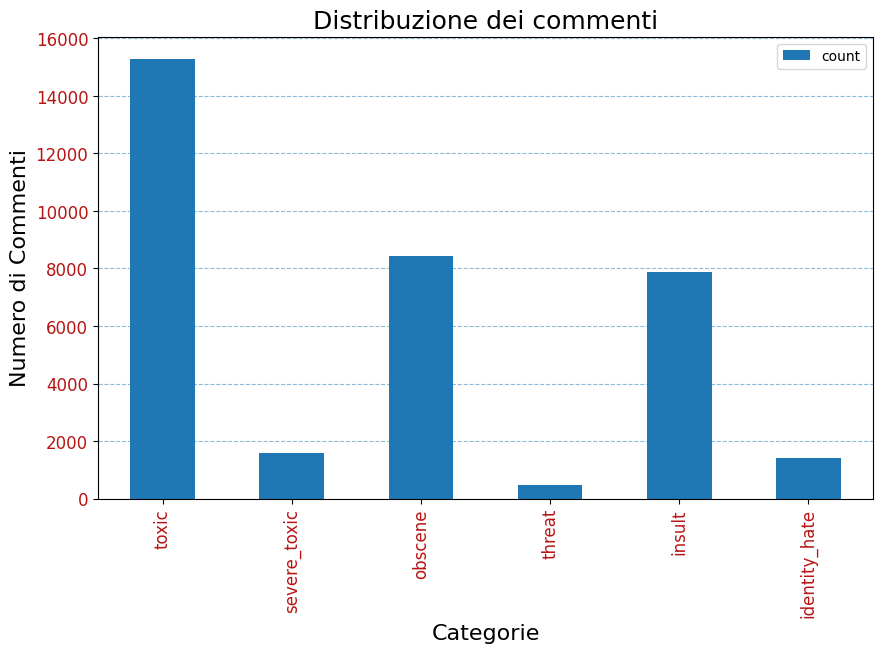

In [243]:
class_distribution.plot(kind='bar', figsize=(10, 6))
plt.ylabel("Numero di Commenti", fontsize=16)
plt.xlabel("Categorie", fontsize=16)
plt.xticks(fontsize=12, color='#b81414')
plt.title("Distribuzione dei commenti", fontsize=18)
plt.yticks(fontsize=12, color='#b81414')
plt.grid(axis='y', linestyle='--', alpha=0.5, color="#1f77b4")
plt.show()

In [109]:
class_proportion = (class_distribution / df_hater.shape[0])*10

print_colored("Distribuzione dei commenti in percentuale:\n", "blue")
print(class_proportion)

Distribuzione dei commenti in percentuale:

toxic            0.958445
severe_toxic     0.099956
obscene          0.529482
threat           0.029955
insult           0.493636
identity_hate    0.088049
dtype: float64


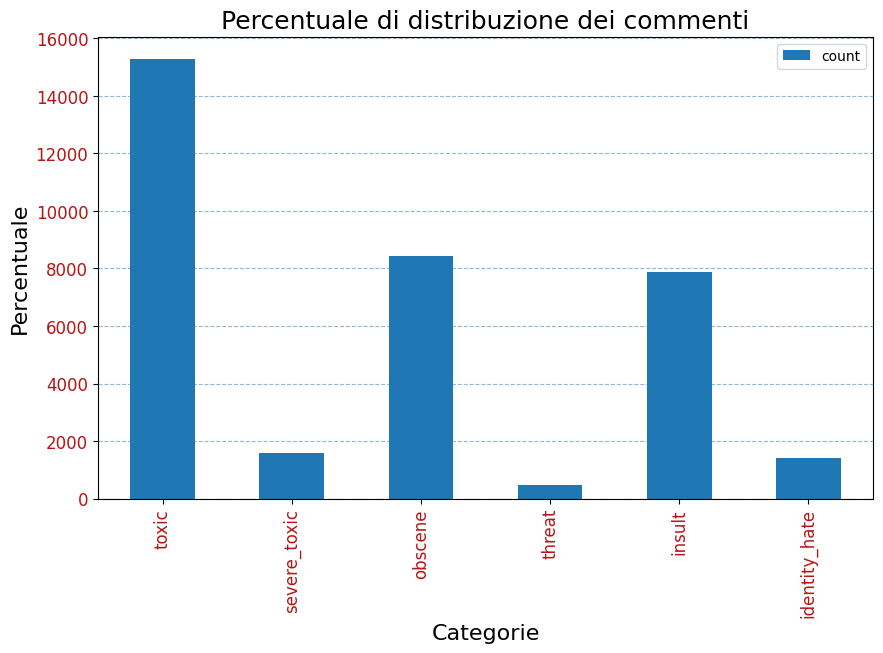

In [241]:
class_distribution.plot(kind='bar', figsize=(10, 6))
plt.title("Percentuale di distribuzione dei commenti", fontsize=18)
plt.xlabel("Categorie", fontsize=16)
plt.ylabel("Percentuale", fontsize=16)
plt.xticks(fontsize=12, color='#b81414')
plt.yticks(fontsize=12, color='#b81414')
plt.grid(axis='y', linestyle='--', alpha=0.5, color="#1f77b4")
plt.show()

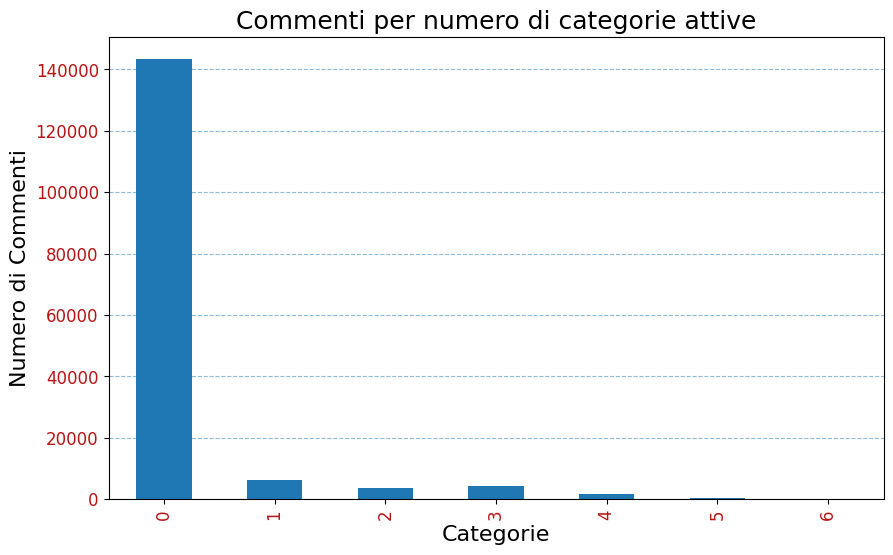

Numero di commenti non classificati, quindi non tossici:
143346
Numero di commenti con una categoria attiva:
6360
Numero di commenti con due categorie attive:
3480
Numero di commenti con tre categorie attive:
4209
Numero di commenti con quattro categorie attive:
1760
Numero di commenti con cinque categorie attive:
385
Numero di commenti con sei categorie attive:
31


In [240]:
# Calcolo il numero di etichette attive per ogni commento
df_hater['label_count'] = df_hater[categories].sum(axis=1)

# Distribuzione del numero di etichette attive
multi_label_distribution = df_hater['label_count'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
multi_label_distribution.plot(kind='bar', )
plt.title("Commenti per numero di categorie attive", fontsize=18)
plt.xlabel("Categorie", fontsize=16)
plt.ylabel("Numero di Commenti", fontsize=16)
plt.xticks(fontsize=12, color='#b81414')
plt.yticks(fontsize=12, color='#b81414')
plt.grid(axis='y', linestyle='--', alpha=0.5, color="#1f77b4")
plt.show()

print_colored("Numero di commenti non classificati, quindi non tossici:", "blue")
print(multi_label_distribution.at[0])

print_colored("Numero di commenti con una categoria attiva:", "blue")
print(multi_label_distribution.at[1])

print_colored("Numero di commenti con due categorie attive:", "blue")
print(multi_label_distribution.at[2])

print_colored("Numero di commenti con tre categorie attive:", "blue")
print(multi_label_distribution.at[3])

print_colored("Numero di commenti con quattro categorie attive:", "blue")
print(multi_label_distribution.at[4])

print_colored("Numero di commenti con cinque categorie attive:", "blue")
print(multi_label_distribution.at[5])

print_colored("Numero di commenti con sei categorie attive:", "blue")
print(multi_label_distribution.at[6])

## <font color='red'>Preprocessing dei dati</font>

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inizializzo stopwords e lemmatizer
stop_words = set(stopwords.words('english'))  # Stopword per la lingua inglese
                                              # Rimuove parole comuni italiane per ridurre il rumore nei dati
lemmatizer = WordNetLemmatizer() # Riduce le parole alla loro forma base per 
                                 # diminuire la dimensionalità del vocabolario.

def clean_text(text):
    # Rimuovo caratteri speciali e punteggiatura
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Converto tutte le lettere in minuscolo
    text = text.lower()

    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Ricostruisco il testo pulito
    return ' '.join(tokens)

def preprocess_data(df_hater, categories):
    # Pulizia del testo
    df_hater['comment_text'] = df_hater['comment_text'].apply(clean_text)
    
    # Tokenizzazione
    tokenizer = Tokenizer()  # Non limitiamo il vocabolario
    tokenizer.fit_on_texts(df_hater['comment_text'])  # Adatta il tokenizer ai testi
    sequences = tokenizer.texts_to_sequences(df_hater['comment_text'])  # Trasforma i testi in sequenze numeriche
    
    # Labels
    labels = df_hater[categories].values
    
    return sequences, labels, tokenizer

# Preprocessing
sequences, labels, tokenizer = preprocess_data(df_hater, categories)

In [754]:
# Salvo il tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [202]:
# Verifica del vocabolario
word_index = tokenizer.word_index  # Dizionario parola -> indice
vocab_size = len(word_index)

print_colored("Dimensione del vocabolario:", "blue")
print(vocab_size)

Dimensione del vocabolario:
212562


In [203]:
# Lunghezza delle sequenze (senza padding)
sequence_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(df_hater['comment_text'])]

# Statistiche sulla lunghezza
min_length = min(sequence_lengths)
max_length = max(sequence_lengths)
avg_length = sum(sequence_lengths) / len(sequence_lengths)


print_colored("Lunghezza minima:", "blue")
print(min_length)
print_colored("Lunghezza massima:", "blue")
print(max_length)
print_colored("Lunghezza media delle sequenze:", "blue")
print(f"{avg_length:.2f}")

Lunghezza minima:
0
Lunghezza massima:
1250
Lunghezza media delle sequenze:
34.67


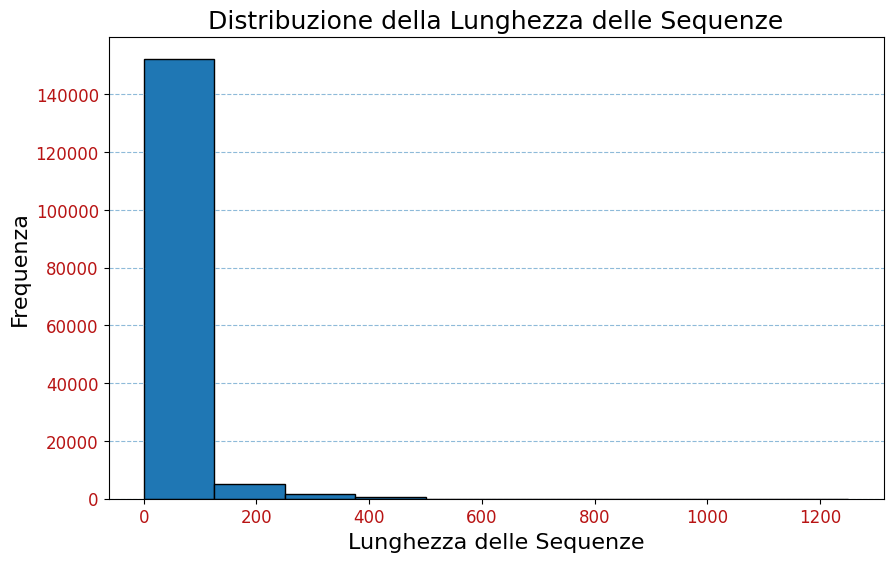

In [239]:
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=10, edgecolor='black')
plt.title("Distribuzione della Lunghezza delle Sequenze", fontsize=18)
plt.xlabel("Lunghezza delle Sequenze", fontsize=16, color='black')
plt.ylabel("Frequenza", fontsize=16, color='black')
plt.xticks(fontsize=12, color='#b81414')
plt.yticks(fontsize=12, color='#b81414')
plt.grid(axis='y', linestyle='--', alpha=0.5, color="#1f77b4")
plt.show()

In [209]:
# Tokenizzazione dei commenti (eseguita una sola volta)
tokenized_sequences = tokenizer.texts_to_sequences(df_hater['comment_text'])  # Tokenizzazione dei commenti
sequence_lengths = [len(seq) for seq in tokenized_sequences]  # Calcola le lunghezze delle sequenze

# Intervalli di lunghezza
outlier_thresholds = [
    (0, 20),
    (21, 50),
    (51, 100),
    (101, 200),
    (201, 300),
    (301, 400),
    (401, 600),
    (601, 1250)
]

# Commenti per ciascun intervallo
counts = []
for low, high in outlier_thresholds:
    count = sum(1 for length in sequence_lengths if low <= length <= high)
    counts.append((low, high, count))

for low, high, count in counts:
    print_colored(f"Numero di commenti con lunghezza compresa tra {low} e {high} token:", "blue")
    print(count)

Numero di commenti con lunghezza compresa tra 0 e 20 token:
86418
Numero di commenti con lunghezza compresa tra 21 e 50 token:
44601
Numero di commenti con lunghezza compresa tra 51 e 100 token:
18214
Numero di commenti con lunghezza compresa tra 101 e 200 token:
7137
Numero di commenti con lunghezza compresa tra 201 e 300 token:
1620
Numero di commenti con lunghezza compresa tra 301 e 400 token:
1021
Numero di commenti con lunghezza compresa tra 401 e 600 token:
500
Numero di commenti con lunghezza compresa tra 601 e 1250 token:
60


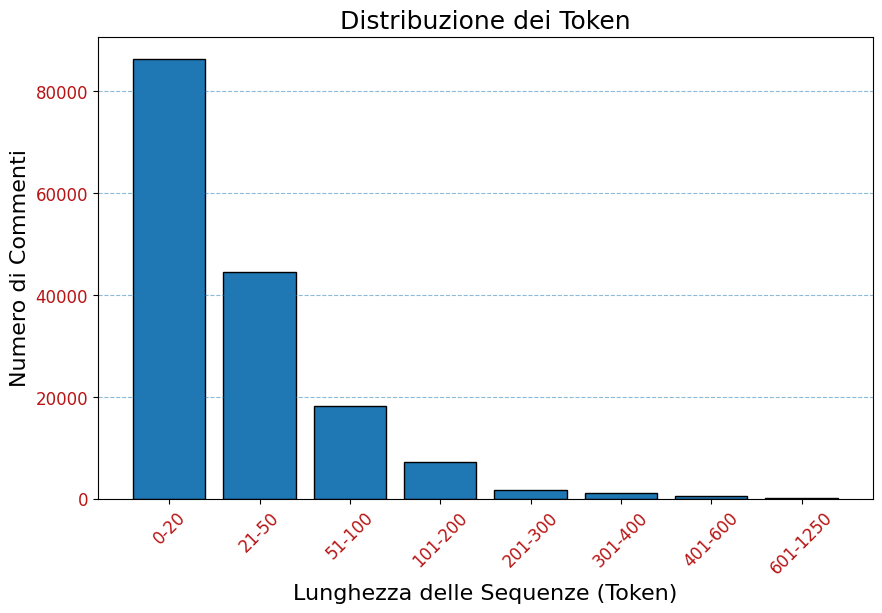

In [682]:
interval_labels = [f"{low}-{high}" for low, high, _ in counts]  # Etichette degli intervalli
frequencies = [count for _, _, count in counts]

plt.figure(figsize=(10, 6))
plt.bar(interval_labels, frequencies, color="#1f77b4", edgecolor='black')
plt.title("Distribuzione dei Token", fontsize=18)
plt.xlabel("Lunghezza delle Sequenze (Token)", fontsize=16, color='black')
plt.ylabel("Numero di Commenti", fontsize=16, color='black')
plt.xticks(fontsize=12, color='#b81414', rotation=45)
plt.yticks(fontsize=12, color='#b81414')
plt.grid(axis='y', linestyle='--', alpha=0.5, color="#1f77b4")
plt.show()

### *I commenti estremamente lunghi sono poco frequenti nel dataset rispetto alle sequenze corte. Per questo motivo, li considererò come outlier*


In [210]:
# Applico il padding
max_len = 400  # Lunghezza massima scelta
padded_sequences = pad_sequences(tokenized_sequences, maxlen=max_len, padding='post', truncating='post')

print(padded_sequences[:5])

[[  457    57    60 ...     0     0     0]
 [85242   940  1175 ...     0     0     0]
 [  318   313    17 ...     0     0     0]
 [  122    22   238 ...     0     0     0]
 [ 1442  2369   765 ...     0     0     0]]


In [212]:
for category in categories:
    counts = df_hater[category].value_counts()
    print_colored(f"Distribuzione per {category}:", "blue")
    print(counts)
    print()

Distribuzione per toxic:
toxic
0    144277
1     15294
Name: count, dtype: int64

Distribuzione per severe_toxic:
severe_toxic
0    157976
1      1595
Name: count, dtype: int64

Distribuzione per obscene:
obscene
0    151122
1      8449
Name: count, dtype: int64

Distribuzione per threat:
threat
0    159093
1       478
Name: count, dtype: int64

Distribuzione per insult:
insult
0    151694
1      7877
Name: count, dtype: int64

Distribuzione per identity_hate:
identity_hate
0    158166
1      1405
Name: count, dtype: int64



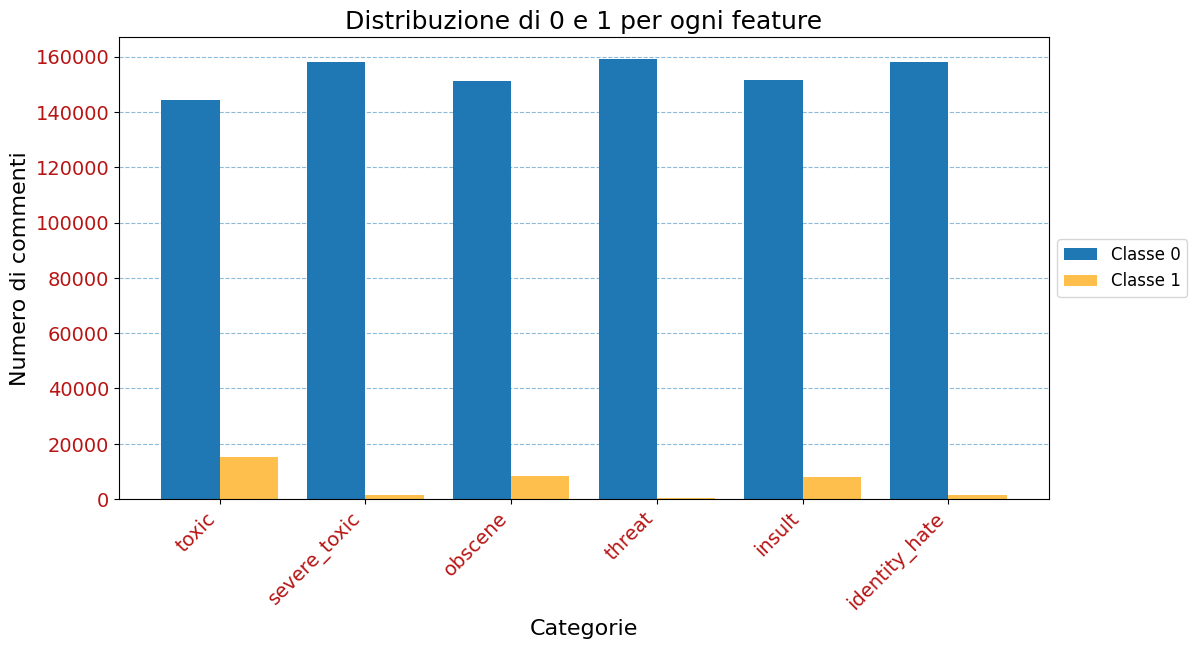

In [685]:
# 0 e 1 per ogni feature
feature_counts = {feature: df_hater[feature].value_counts() for feature in categories}

features = list(feature_counts.keys())
counts_0 = [feature_counts[feature].get(0, 0) for feature in features]
counts_1 = [feature_counts[feature].get(1, 0) for feature in features]

# Intervallo per le barre
x = np.arange(len(features))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, counts_0, width=width, label='Classe 0', color='#1f77b4')
plt.bar(x + width/2, counts_1, width=width, label='Classe 1', color='orange', alpha=0.7)

plt.title("Distribuzione di 0 e 1 per ogni feature", fontsize=18)
plt.xlabel("Categorie", fontsize=16, color="black")
plt.ylabel("Numero di commenti", fontsize=16, color="black")
plt.xticks(x, features, fontsize=14, rotation=45, ha='right', color="#b81414")
plt.yticks(fontsize=14, color="#b81414")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5, color="#1f77b4")

plt.show()

### *Analizzando i dati, si nota che le categorie sono poco sbilanciate tra loro, ma all'interno di ciascuna categoria le classi mostrano un forte squilibrio. Addestrare il modello con questi dati potrebbe portare a una distorsione verso la classe di maggioranza, penalizzando la performance sulla classe minoritaria. Per mitigare questo problema, applicherò il sovracampionamento. Invece di duplicare semplicemente i dati esistenti, utilizzerò tecniche come SMOTE per generare nuovi campioni sintetici che rappresentino meglio la distribuzione della classe minoritaria, riducendo il rischio di overfitting e bias.*

## <font color='red'>Divisione del dataset</font>

## *70% per il training set, 15% per il set di validazione e 15% per il set di test applicando stratify per garantire che la suddivisione dei dati preservi la proporzione delle classi ed evitare che una classe sia sottorappresentata o assente. Per rappresentare la distribuzione reale.*

In [283]:
# Estraggo i valori dalle colonne
labels_df = df_hater[categories].values

# Creo una etichetta che rappresenta il numero totale di classi positive per ogni campione
# Questo è necessario per stratificare i dati preservando la distribuzione multi-classe
stratify_labels_df = labels_df.sum(axis=1)

# Verifico che il numero di campioni nei dati corrisponda al numero di etichette
assert len(padded_sequences) == len(labels_df), 

X_train_mlsmote, X_temp_mlsmote, y_train_mlsmote, y_temp_mlsmote = train_test_split(
    padded_sequences, labels_df, test_size=0.3, random_state=42, stratify=stratify_labels_df
)

stratify_temp_labels_df = y_temp_mlsmote.sum(axis=1)

X_val_mlsmote, X_test_mlsmote, y_val_mlsmote, y_test_mlsmote = train_test_split(
    X_temp_mlsmote, y_temp_mlsmote, test_size=0.5, random_state=42, stratify=stratify_temp_labels_df
)

print_colored(f"Dimensione Training Set:", "blue")
print(len(X_train_mlsmote))
print_colored(f"Dimensione Validation Set:", "blue")
print(len(X_val_mlsmote))
print_colored(f"Dimensione Test Set:", "blue")
print(len(X_test_mlsmote))

Dimensione Training Set:
111699
Dimensione Validation Set:
23936
Dimensione Test Set:
23936


## <font color='red'>Implemento il bilanciamento delle classi con SMOTE per ciascuna colonna</font>

In [285]:
if not isinstance(X_train_mlsmote, pd.DataFrame):
    X_train_mlsmote = pd.DataFrame(X_train_mlsmote, columns=[f'feature_{i}' for i in range(X_train_mlsmote.shape[1])])
if not isinstance(y_train_mlsmote, pd.DataFrame):
    y_train_mlsmote = pd.DataFrame(y_train_mlsmote, columns=categories)

balanced_datasets = {}

for category in categories:
    print_colored(f"Bilanciando la classe:", "blue")
    print_colored(category, "red")
    
    smote = SMOTE(random_state=42)
    
    # Applico SMOTE per la specifica colonna
    X_resampled, y_resampled = smote.fit_resample(X_train_mlsmote, y_train_mlsmote[category])
    
    # Salvo il risultato per la colonna bilanciata
    balanced_datasets[category] = {
        "X_resampled": X_resampled,
        "y_resampled": y_resampled
    }
   

    print(f"Distribuzione bilanciata per {category}: {Counter(y_resampled)}")
    print()

# Ogni chiave contiene "X_resampled" e "y_resampled".
print_colored("Bilanciamento completato per tutte le classi.", "blue")

Bilanciando la classe:
toxic
Distribuzione bilanciata per toxic: Counter({0: 100996, 1: 100996})

Bilanciando la classe:
severe_toxic
Distribuzione bilanciata per severe_toxic: Counter({0: 110589, 1: 110589})

Bilanciando la classe:
obscene
Distribuzione bilanciata per obscene: Counter({0: 105787, 1: 105787})

Bilanciando la classe:
threat
Distribuzione bilanciata per threat: Counter({0: 111374, 1: 111374})

Bilanciando la classe:
insult
Distribuzione bilanciata per insult: Counter({0: 106170, 1: 106170})

Bilanciando la classe:
identity_hate
Distribuzione bilanciata per identity_hate: Counter({0: 110711, 1: 110711})

Bilanciamento completato per tutte le classi.


In [286]:
# Converto dict_keys in una lista per l'accesso tramite indice
categories_list = list(categories)  # Se categories è dict_keys

# Combino i dati riequilibrati per il training
X_train_balanced = balanced_datasets[categories_list[0]]["X_resampled"]
y_train_balanced = pd.concat(
    [pd.DataFrame(balanced_datasets[cat]["y_resampled"], columns=[cat]) for cat in categories_list],
    axis=1
)

print_colored(f"Dimensione X_train_balanced:", "blue")
print(X_train_balanced.shape)
print_colored(f"Dimensione y_train_balanced:", "blue")
print(y_train_balanced.shape)

Dimensione X_train_balanced:
(201992, 400)
Dimensione y_train_balanced:
(222748, 6)


In [287]:
for category in categories:
    print_colored(category, "blue")
    print(f"Dimensioni X_resampled: {balanced_datasets[category]['X_resampled'].shape}")
    print(f"Dimensioni y_resampled: {balanced_datasets[category]['y_resampled'].shape}")
    print()

toxic
Dimensioni X_resampled: (201992, 400)
Dimensioni y_resampled: (201992,)

severe_toxic
Dimensioni X_resampled: (221178, 400)
Dimensioni y_resampled: (221178,)

obscene
Dimensioni X_resampled: (211574, 400)
Dimensioni y_resampled: (211574,)

threat
Dimensioni X_resampled: (222748, 400)
Dimensioni y_resampled: (222748,)

insult
Dimensioni X_resampled: (212340, 400)
Dimensioni y_resampled: (212340,)

identity_hate
Dimensioni X_resampled: (221422, 400)
Dimensioni y_resampled: (221422,)



## *Calcolo il numero minimo di campioni per far corrispondere le dimensioni di X_train_balanced e y_train_balanced allo stesso valore*

In [689]:
min_samples = min(len(balanced_datasets[cat]["X_resampled"]) for cat in categories)
print_colored(f"Numero minimo di campioni:", "blue")
print(min_samples)

Numero minimo di campioni:
201992


In [311]:
# Riduco ogni dataset bilanciato alla dimensione minima
X_train_balanced = balanced_datasets[categories_list[0]]["X_resampled"][:min_samples]

# Combino le etichette per tutte le categorie
y_train_balanced = pd.concat(
    [
        pd.DataFrame(balanced_datasets[cat]["y_resampled"][:min_samples], columns=[cat])
        for cat in categories
    ],
    axis=1
)

print(f"Dimensione X_train_balanced: {X_train_balanced.shape}")
print(f"Dimensione y_train_balanced: {y_train_balanced.shape}")

Dimensione X_train_balanced: (201992, 400)
Dimensione y_train_balanced: (201992, 6)


### *Il bilanciamento è avvenuto a livello di singola classe, trattandola come un problema binario. Questo è ideale per problemi multi-label in cui ogni classe è indipendente.*

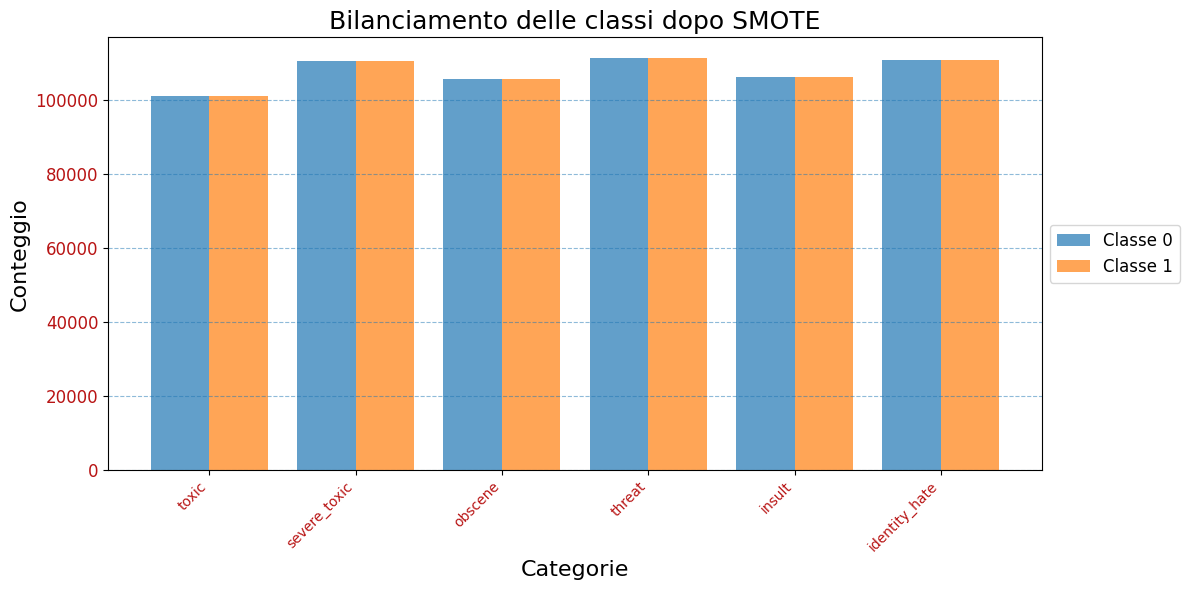

In [698]:
categories = balanced_datasets.keys()
counts_per_category = {
    category: Counter(balanced_datasets[category]["y_resampled"])
    for category in categories
}

counts_0 = [counts_per_category[cat][0] for cat in categories]
counts_1 = [counts_per_category[cat][1] for cat in categories]

x = np.arange(len(categories))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - width / 2, counts_0, width, label="Classe 0", alpha=0.7)
plt.bar(x + width / 2, counts_1, width, label="Classe 1", alpha=0.7)

plt.xlabel("Categorie", fontsize=16, color='black')
plt.ylabel("Conteggio", fontsize=16, color='black')
plt.title("Bilanciamento delle classi dopo SMOTE", fontsize=18)
plt.xticks(x, categories, rotation=45, ha='right', color='#b81414')
plt.yticks(fontsize=12, color='#b81414')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5, color="#1f77b4")

plt.tight_layout()
plt.show()

In [699]:
vocab_size_padding = len(tokenizer.word_index) + 1  # Aggiungi 1 per il token di padding
print_colored(f"Vocab size padding:", "blue")
print(vocab_size_padding)

Vocab size padding:
212563


In [324]:
clear_session()

## <font color='red'>Creazione del primo modello</font>

In [325]:
model = Sequential()

# Ho dovuto aggiungere i valori in modo esplicito per non farmi restituire 'unbuilt'
model.add(Input(shape=(400,), name='input_layer'))

model.add(Embedding(
    input_dim=212563,  # vocab_size_padding
    output_dim=128,
    name='embedding_layer'
))

model.add(Bidirectional(a
    LSTM(64, activation='tanh'),
    name='bidirectional_lstm'
))

model.add(Dense(6, activation='sigmoid', name='output_layer'))  # num_labels = 6

# Compilazione
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 400, 128)       │    27,208,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,307,654 (104.17 MB)

 Trainable params: 27,307,654 (104.17 MB)

 Non-trainable params: 0 (0.00 B)

In [326]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # metrica da monitorare
    patience=2,                # numero di epoche da aspettare prima di fermarsi
    restore_best_weights=True, # ripristina i migliori pesi
    mode='min',                # minimizzare la loss
    min_delta=0.001,           # cambiamento minimo da considerare come miglioramento
)

In [327]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,              # riduce il learning rate dopo 1 epoca senza miglioramenti
    min_lr=1e-6,
    verbose=1
)

In [329]:
model_checkpoint_path = "anti_hater_model_stratify_400_128_6__1.keras"

# Callback per salvare il miglior modello basato sulla metrica monitorata
model_checkpoint = ModelCheckpoint(
    filepath=model_checkpoint_path,   # Percorso per salvare il modello
    monitor='val_loss',               # Metrica da monitorare
    save_best_only=True,              # Salva solo il modello migliore
    save_weights_only=False,          # Salva l'intero modello (inclusa l'architettura)
    mode='min',                       # minimizzare la val_loss
    verbose=1                        
)

In [330]:
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    validation_data=(X_val_mlsmote, y_val_mlsmote),# Usa i dati di validazione originali l set di validazione serve per monitorare il 
                                                     # progresso del modello durante il training
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint], 
    verbose=1
)

print(f"Il miglior modello è stato salvato in: {model_checkpoint_path}")

Epoch 1/5
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8102 - loss: 0.4710
Epoch 1: val_loss improved from inf to 0.29014, saving model to anti_hater_model_stratify_400_128_6__1.keras
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 916s 145ms/step - accuracy: 0.8102 - loss: 0.4709 - val_accuracy: 0.8091 - val_loss: 0.2901 - learning_rate: 0.0010
Epoch 2/5
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7150 - loss: 0.2032
Epoch 2: val_loss improved from 0.29014 to 0.26987, saving model to anti_hater_model_stratify_400_128_6__1.keras
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 914s 145ms/step - accuracy: 0.7150 - loss: 0.2032 - val_accuracy: 0.8569 - val_loss: 0.2699 - learning_rate: 0.0010
Epoch 3/5
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6883 - loss: 0.1091
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_loss did not improve from 0.26987
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 913s 145ms/step - accuracy: 0.6883 - loss: 0.1091 - val_accur

## <font color='red'>Valutazione del primo modello sul test set</font>

In [596]:
print("\nValutazione sul Test Set:")
y_test_pred = model.predict(X_test_mlsmote)  # Predizioni sul test set
y_test_pred_binary = (y_test_pred > 0.5).astype(int)  # Converto probabilità in etichette binarie

test_metrics_df = pd.DataFrame()
test_metrics_df['Category'] = categories

test_accuracies = []
test_f1_scores = []
test_precisions = []

for i in range(len(categories)):
    test_acc = accuracy_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    test_f1 = f1_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    test_prec = precision_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    test_precisions.append(test_prec)

test_metrics_df['Accuracy'] = test_accuracies
test_metrics_df['F1-Score'] = test_f1_scores
test_metrics_df['Precision'] = test_precisions

print("\nMetriche del Test Set:")
print(test_metrics_df)

print("\nInferenza su alcuni esempi del Test Set:")

num_examples = 15
for idx in range(num_examples):
    comment = X_test_mlsmote[idx]
    true_labels = y_test_mlsmote[idx]
    predicted_probs = y_test_pred[idx]
    predicted_labels = y_test_pred_binary[idx]
    
    print(f"Commento #{idx + 1}:")
    print(f" - Predetto: {predicted_labels} (probabilità: {predicted_probs.round(2)})")
    print(f" - Vero: {true_labels}")
    print("-" * 50)


Valutazione sul Test Set:
748/748 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step

Metriche del Test Set:
        Category  Accuracy  F1-Score  Precision
0          toxic  0.869694  0.527209   0.403855
1   severe_toxic  0.897518  0.063383   0.034992
2        obscene  0.887701  0.423176   0.291113
3         threat  0.902323  0.007640   0.003953
4         insult  0.879428  0.358096   0.241960
5  identity_hate  0.896892  0.027581   0.015002

Inferenza su alcuni esempi del Test Set:
Commento #1:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.12 0.   0.01 0.   0.01 0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #2:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.01 0.   0.   0.   0.   0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #3:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.01 0.   0.   0.   0.   0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #4:
 - Predetto: [0 0 0 0 0 0] (prob

In [701]:
# Calcolo la Hamming Loss tra le etichette vere (ytest) e le etichette predette (ypred)
# la somma degli errori tra ytest e il ypred diviso il numero totale di etichette
global_hamming_loss = hamming_loss(y_test_mlsmote, y_test_pred_binary)

# Inverto la Hamming Loss per ottenere la Global Accuracy
global_accuracy_1 = 1 - global_hamming_loss

print_colored(f"Precisione Globale (Global Accuracy):", "blue")
print(f"{global_accuracy_1:.4f}")

Precisione Globale (Global Accuracy):
0.8844


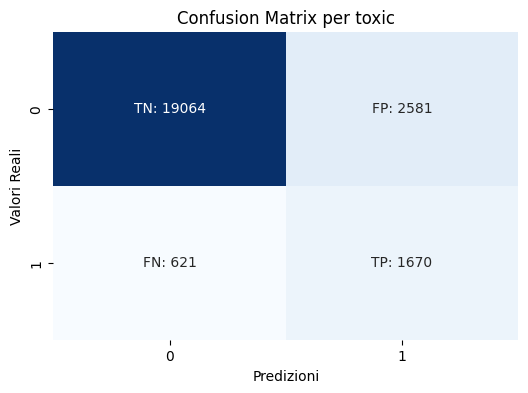

Confusion Matrix per toxic:
[[19064  2581]
 [  621  1670]]


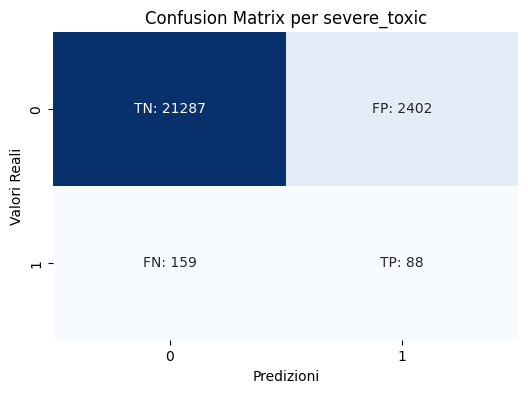

Confusion Matrix per severe_toxic:
[[21287  2402]
 [  159    88]]


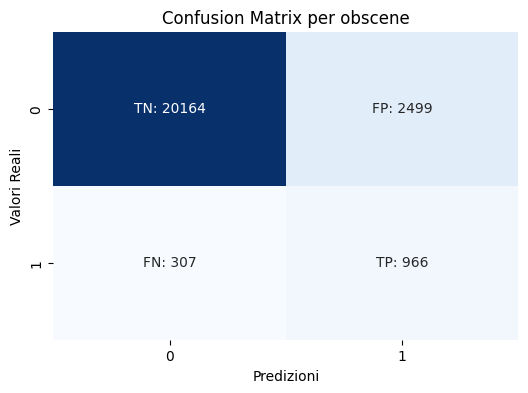

Confusion Matrix per obscene:
[[20164  2499]
 [  307   966]]


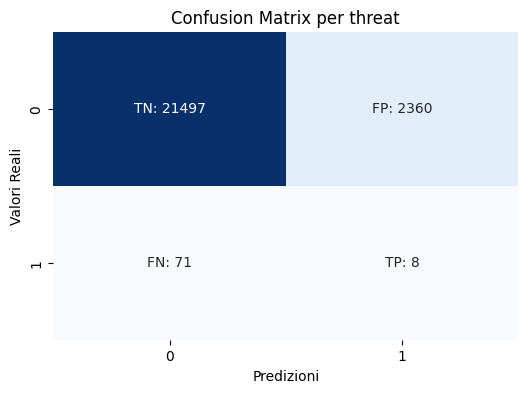

Confusion Matrix per threat:
[[21497  2360]
 [   71     8]]


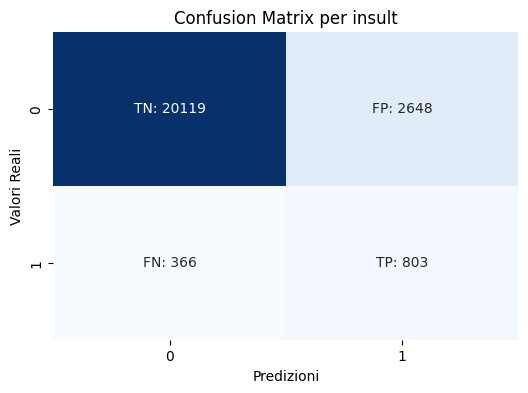

Confusion Matrix per insult:
[[20119  2648]
 [  366   803]]


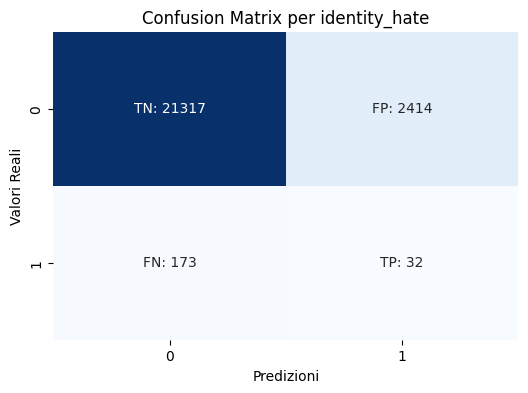

Confusion Matrix per identity_hate:
[[21317  2414]
 [  173    32]]


In [333]:
conf_matrices = multilabel_confusion_matrix(y_test_mlsmote, y_test_pred_binary)

# Controllo dimensioni
if conf_matrices.shape[0] != len(categories):
    print("Errore: Il numero di confusion matrix non corrisponde al numero di categorie.")
else:
    for i, category in enumerate(categories):
        plt.figure(figsize=(6, 4))
        
        conf_matrix = conf_matrices[i]
        
        labels = np.array([['TN', 'FP'], ['FN', 'TP']])
        annotated_matrix = np.empty_like(conf_matrix, dtype=object)
        for row in range(conf_matrix.shape[0]):
            for col in range(conf_matrix.shape[1]):
                annotated_matrix[row, col] = f"{labels[row, col]}: {conf_matrix[row, col]}"
        
        sns.heatmap(conf_matrix, annot=annotated_matrix, fmt='', cmap='Blues', cbar=False)
        plt.title(f"Confusion Matrix per {category}")
        plt.xlabel("Predizioni")
        plt.ylabel("Valori Reali")
        plt.show()
        
        print(f"Confusion Matrix per {category}:")
        print(conf_matrix)

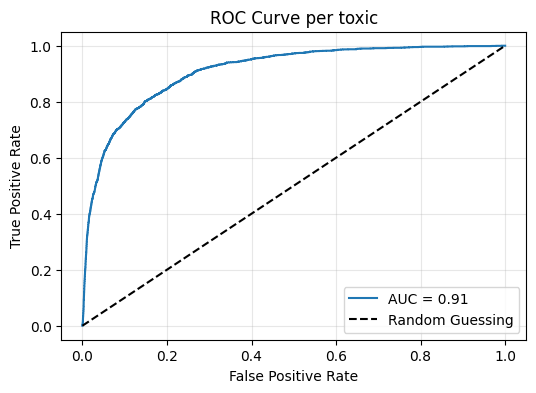

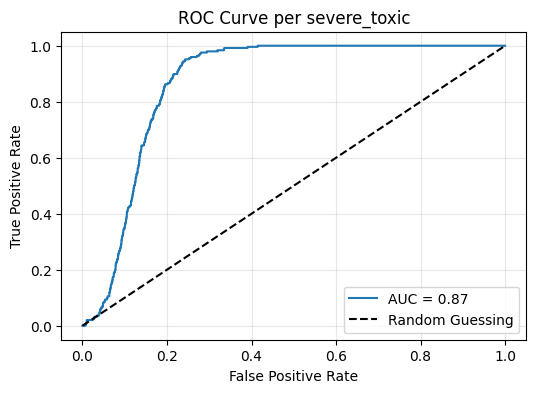

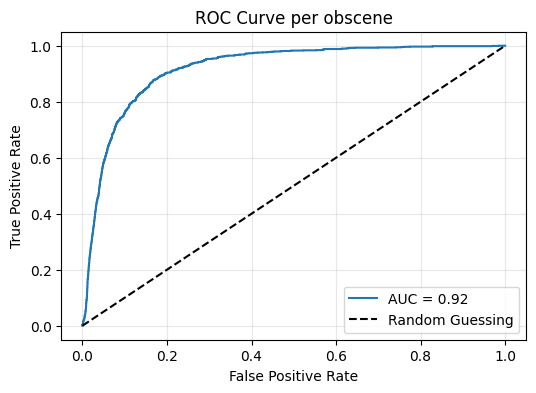

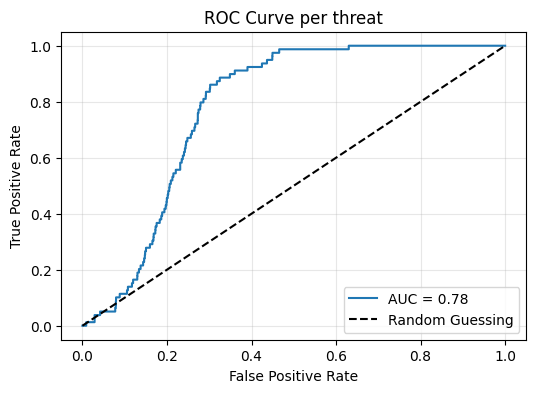

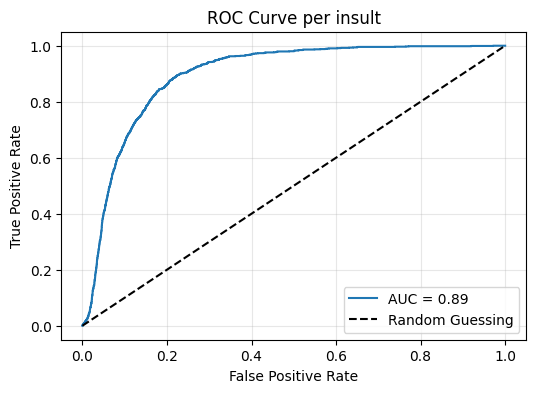

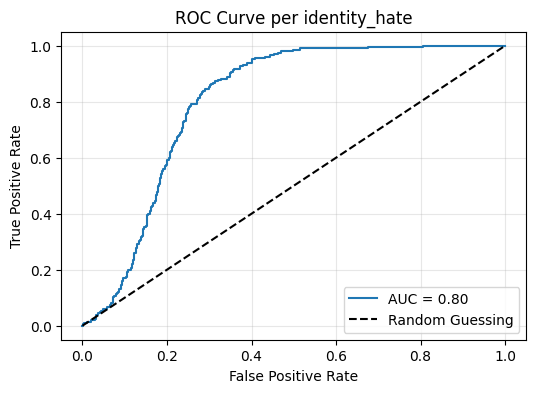

In [597]:
for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test_mlsmote[:, i], y_test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title(f"ROC Curve per {category}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


Precision-Recall per toxic (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.10        1.00        
0.00      0.11        1.00        
0.01      0.12        0.99        
0.01      0.14        0.98        
0.03      0.17        0.96        
0.07      0.20        0.93        
0.16      0.25        0.87        
0.37      0.34        0.78        
0.75      0.53        0.61        
1.00      1.00        0.00        


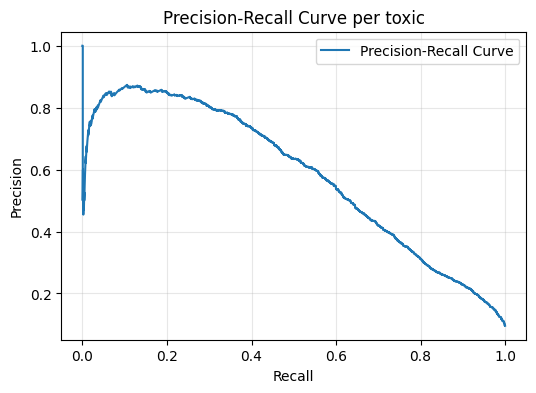


Precision-Recall per severe_toxic (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.02        1.00        
0.01      0.02        1.00        
0.02      0.02        0.99        
0.06      0.03        0.96        
0.18      0.04        0.82        
0.47      0.04        0.38        
1.00      0.00        0.00        


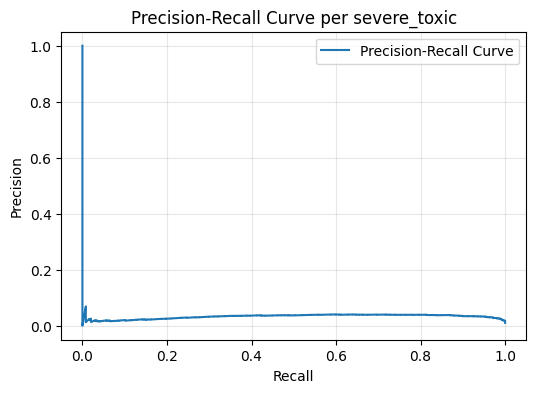


Precision-Recall per obscene (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.05        1.00        
0.00      0.06        1.00        
0.00      0.07        0.99        
0.01      0.08        0.98        
0.01      0.09        0.98        
0.03      0.11        0.96        
0.09      0.15        0.92        
0.26      0.20        0.85        
0.63      0.33        0.69        
1.00      1.00        0.00        


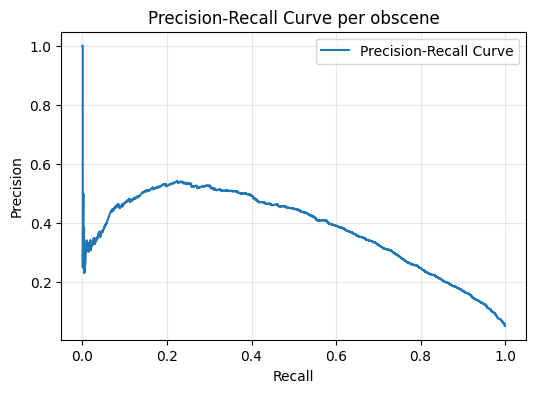


Precision-Recall per threat (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.00        1.00        
0.00      0.00        1.00        
0.00      0.00        1.00        
0.00      0.00        0.99        
0.01      0.01        0.96        
0.02      0.01        0.89        
0.06      0.01        0.73        
0.17      0.01        0.43        
0.45      0.00        0.13        
1.00      0.00        0.00        


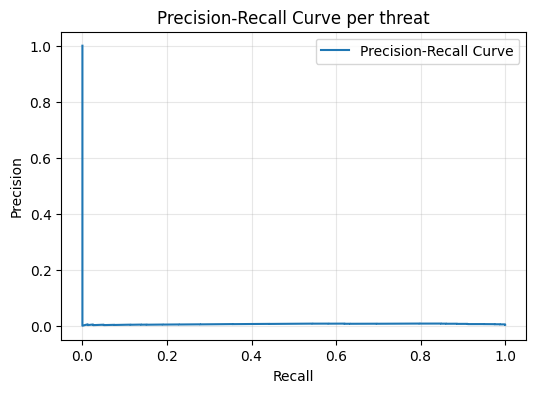


Precision-Recall per insult (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.05        1.00        
0.00      0.05        1.00        
0.00      0.06        0.99        
0.01      0.07        0.99        
0.01      0.09        0.98        
0.04      0.11        0.96        
0.10      0.13        0.91        
0.27      0.18        0.81        
0.62      0.27        0.62        
1.00      0.00        0.00        


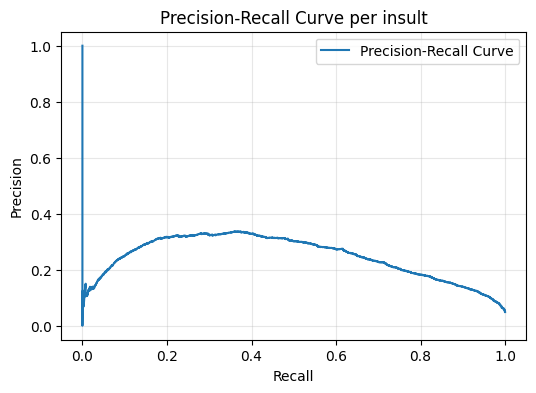


Precision-Recall per identity_hate (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.01        0.99        
0.01      0.02        0.98        
0.02      0.02        0.91        
0.07      0.02        0.82        
0.19      0.02        0.57        
0.47      0.01        0.18        
1.00      0.00        0.00        


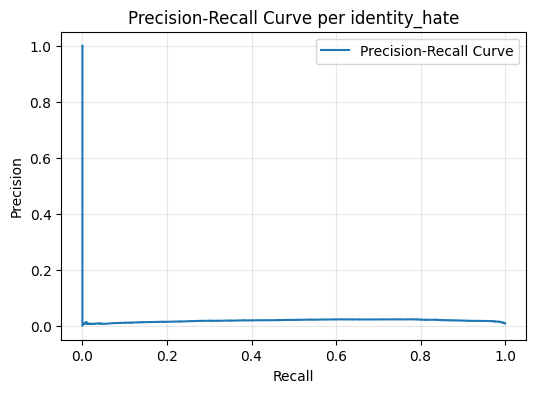

In [335]:
for i, category in enumerate(categories):
    precision, recall, thresholds = precision_recall_curve(y_test_mlsmote[:, i], y_test_pred[:, i])
    
    print(f"\nPrecision-Recall per {category} (valori campionati):")
    print(f"{'Threshold':<10}{'Precision':<12}{'Recall':<12}")
    print("-" * 34)
    
    sampled_indices = np.linspace(0, len(thresholds) - 1, 10, dtype=int)  # Campiona 10 valori
    for idx in sampled_indices:
        print(f"{thresholds[idx]:<10.2f}{precision[idx]:<12.2f}{recall[idx]:<12.2f}")
    
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.title(f"Precision-Recall Curve per {category}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.show()

### *I valori di val_accuracy, Auc Roc e Global Accuracy non sono bassi ma alcune categorie presentano valori bassissimi di F1-score e Precision. Il modello tende a classificare molti commenti innocui come tossici.*

## <font color='red'>Creazione di un secondo modello LSTM usando come base il primo modello</font>

In [355]:
def load_model_safely(path):
    try:
        model = load_model(path)
        return model
    except Exception as e:
        print(f"Errore nel caricamento del modello: {e}")
        return None

model_checkpoint_path = "/home/gap/Scrivania/Filtro_anti_hater/anti_hater_model_stratify_400_128_6__1.keras"

first_model = load_model_safely(model_checkpoint_path)

if first_model is None:
    print("Impossibile caricare il modello. Controllare il file del modello.")
else:

    # Preservo i pesi già addestrati per evitare che vengano riaddestrati
    for layer in first_model.layers:
        layer.trainable = False  # Congelo tutti i layer esistenti
    
    print("Sommario del Modello:")
    first_model.summary()

    # Estraggo la forma dell'input, rimuovendo la dimensione del batch
    if isinstance(first_model.input_shape, tuple):
        input_shape = first_model.input_shape[1:]  # Rimuove la dimensione del batch
    else:
        input_shape = first_model.input_shape[0][1:]  # input multipli
    
    # Creo un nuovo strato di input con la forma estratta
    inputs = Input(shape=input_shape)
    
    # Clono i layer del modello originale (escludendo l'ultimo layer di output)
    x = inputs
    for layer in first_model.layers[:-1]:
        x = layer(x)
    
    # Nuovi layer
    x = Dense(64, activation='relu', name='new_dense_1')(x)
    
    # Layer di Dropout per ridurre l'overfitting
    x = Dropout(0.5, name='new_dropout')(x)
    
    x = Dense(32, activation='relu', name='new_dense_2')(x)
    
    # Layer di output con 6 neuroni e attivazione sigmoid per classificazione multi-label
    output_layer = Dense(6, activation='sigmoid', name='new_output_layer')(x)
    
    second_model = Model(inputs=inputs, outputs=output_layer)
    
    second_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # Funzione di perdita per problemi multi-label
        metrics=['accuracy']  # Metrica per valutare le prestazioni
    )
    
    second_model.summary()  

Sommario del Modello:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 400, 128)       │    27,208,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,922,964 (312.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,307,654 (104.17 MB)

 Optimizer params: 54,615,310 (208.34 MB)

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 400, 128)       │    27,208,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_dense_1 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_dropout (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_dense_2 (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_output_layer (Dense)        │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,317,414 (104.21 MB)

 Trainable params: 10,534 (41.15 KB)

 Non-trainable params: 27,306,880 (104.17 MB)

In [357]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # metrica da monitorare
    patience=3,                # numero di epoche da aspettare prima di fermarsi
    restore_best_weights=True, # ripristina i migliori pesi
    mode='min',                # minimizzare la loss
    min_delta=0.001,           # cambiamento minimo da considerare come miglioramento
    verbose=1               
)

In [358]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,           
    min_lr=1e-6,
    verbose=1
)

In [359]:
model_checkpoint_path = "/home/gap/Scrivania/Filtro_anti_hater/anti_hater_model_stratify_400_128_64_32_dropout0.5_6__2.keras"

# Callback per salvare il miglior modello basato sulla metrica monitorata
model_checkpoint = ModelCheckpoint(
    filepath=model_checkpoint_path,   # Percorso per salvare il modello
    monitor='val_loss',               # Metrica da monitorare
    save_best_only=True,              # Salvo solo il modello migliore
    save_weights_only=False,          # Salvo l'intero modello (inclusa l'architettura)
    mode='min',                       # minimizzare la val_loss
    verbose=1                        
)

## <font color='red'>Fit del secondo modello</font>

In [360]:
history = second_model.fit(
    X_train_balanced,
    y_train_balanced,
    validation_data=(X_val_mlsmote, y_val_mlsmote), # dati di validazione originali
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint], 
    verbose=1
)

# Messaggio finale
print(f"Il miglior modello è stato salvato in: {model_checkpoint_path}")

Epoch 1/5
6312/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6845 - loss: 0.1304
Epoch 1: val_loss improved from inf to 0.30043, saving model to /home/gap/Scrivania/Filtro_anti_hater/anti_hater_model_stratify_400_128_64_32_dropout0.5_6__2.keras
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 273s 43ms/step - accuracy: 0.6845 - loss: 0.1304 - val_accuracy: 0.9256 - val_loss: 0.3004 - learning_rate: 0.0010
Epoch 2/5
6312/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7937 - loss: 0.1024
Epoch 2: val_loss improved from 0.30043 to 0.29876, saving model to /home/gap/Scrivania/Filtro_anti_hater/anti_hater_model_stratify_400_128_64_32_dropout0.5_6__2.keras
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 266s 42ms/step - accuracy: 0.7937 - loss: 0.1024 - val_accuracy: 0.9316 - val_loss: 0.2988 - learning_rate: 0.0010
Epoch 3/5
6312/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7844 - loss: 0.1014
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_loss did not improve 

## <font color='red'>Valutazione del secondo modello sul Test Set</font>

In [380]:
print("\nValutazione sul Test Set:")
y_test_pred = second_model.predict(X_test_mlsmote) 
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_metrics_df_2 = pd.DataFrame()
test_metrics_df_2['Category'] = categories

test_accuracies = []
test_f1_scores = []
test_precisions = []

for i in range(len(categories)):
    test_acc = accuracy_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    test_f1 = f1_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    test_prec = precision_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    test_precisions.append(test_prec)

test_metrics_df_2['Accuracy'] = test_accuracies
test_metrics_df_2['F1-Score'] = test_f1_scores
test_metrics_df_2['Precision'] = test_precisions

print("\nMetriche del Test Set:")
print(test_metrics_df_2)


print("\nInferenza su alcuni esempi del Test Set:")

num_examples = 15
for idx in range(num_examples):
    comment = X_test_mlsmote[idx]
    true_labels = y_test_mlsmote[idx]
    predicted_probs = y_test_pred[idx]
    predicted_labels = y_test_pred_binary[idx]
    
    print(f"Commento #{idx + 1}:")
    print(f" - Predetto: {predicted_labels} (probabilità: {predicted_probs.round(2)})")
    print(f" - Vero: {true_labels}")
    print("-" * 50)


Valutazione sul Test Set:
748/748 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step

Metriche del Test Set:
        Category  Accuracy  F1-Score  Precision
0          toxic  0.869527  0.524151   0.402622
1   severe_toxic  0.890709  0.069701   0.038207
2        obscene  0.884442  0.407709   0.280247
3         threat  0.895931  0.007965   0.004112
4         insult  0.876379  0.346655   0.233631
5  identity_hate  0.891544  0.022590   0.012240

Inferenza su alcuni esempi del Test Set:
Commento #1:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.24 0.   0.01 0.   0.02 0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #2:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.01 0.   0.   0.   0.   0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #3:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.01 0.   0.   0.   0.   0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #4:
 - Predetto: [0 0 0 0 0 0] (prob

In [702]:
global_hamming_loss = hamming_loss(y_test_mlsmote, y_test_pred_binary)

global_accuracy_2 = 1 - global_hamming_loss

print_colored(f"Precisione Globale (Global Accuracy):", "blue")
print(f"{global_accuracy_2:.4f}")

Precisione Globale (Global Accuracy):
0.8889


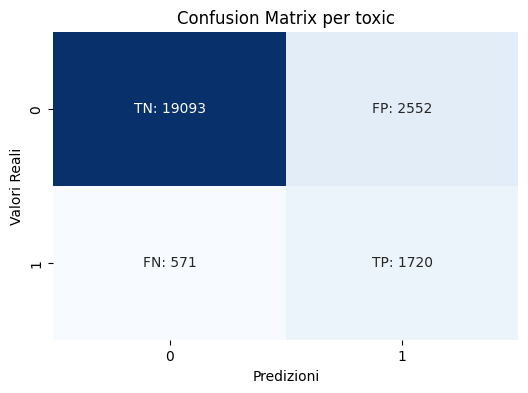

Confusion Matrix per toxic:
[[19093  2552]
 [  571  1720]]


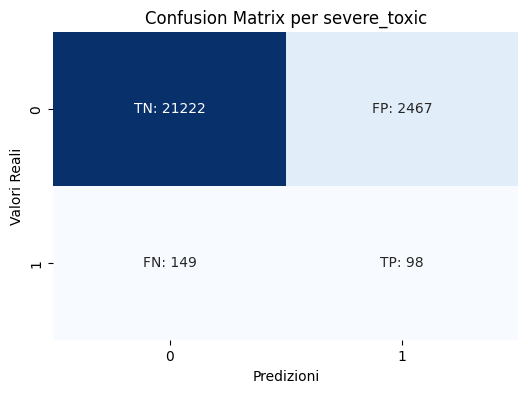

Confusion Matrix per severe_toxic:
[[21222  2467]
 [  149    98]]


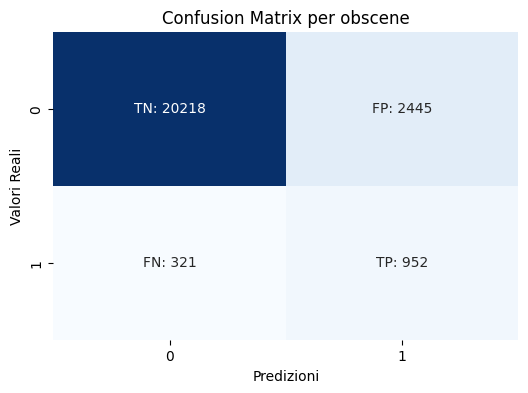

Confusion Matrix per obscene:
[[20218  2445]
 [  321   952]]


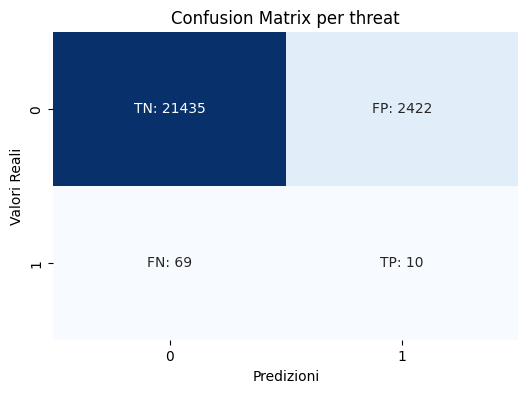

Confusion Matrix per threat:
[[21435  2422]
 [   69    10]]


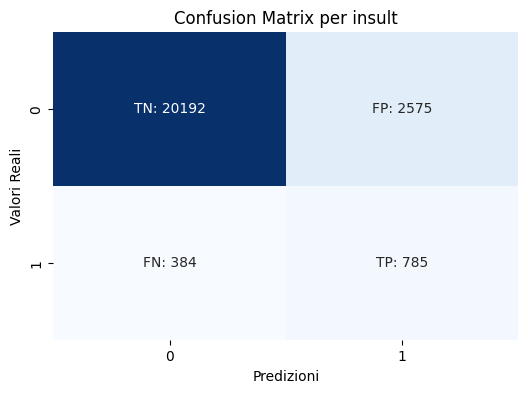

Confusion Matrix per insult:
[[20192  2575]
 [  384   785]]


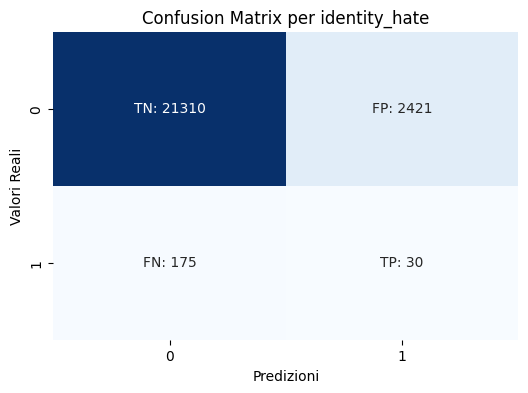

Confusion Matrix per identity_hate:
[[21310  2421]
 [  175    30]]


In [363]:
conf_matrices = multilabel_confusion_matrix(y_test_mlsmote, y_test_pred_binary)

if conf_matrices.shape[0] != len(categories):
    print("Errore: Il numero di confusion matrix non corrisponde al numero di categorie.")
else:
    for i, category in enumerate(categories):
        plt.figure(figsize=(6, 4))
        
        conf_matrix = conf_matrices[i]
        
        labels = np.array([['TN', 'FP'], ['FN', 'TP']])
        annotated_matrix = np.empty_like(conf_matrix, dtype=object)
        for row in range(conf_matrix.shape[0]):
            for col in range(conf_matrix.shape[1]):
                annotated_matrix[row, col] = f"{labels[row, col]}: {conf_matrix[row, col]}"
        
        sns.heatmap(conf_matrix, annot=annotated_matrix, fmt='', cmap='Blues', cbar=False)
        plt.title(f"Confusion Matrix per {category}")
        plt.xlabel("Predizioni")
        plt.ylabel("Valori Reali")
        plt.show()
        
        print(f"Confusion Matrix per {category}:")
        print(conf_matrix)

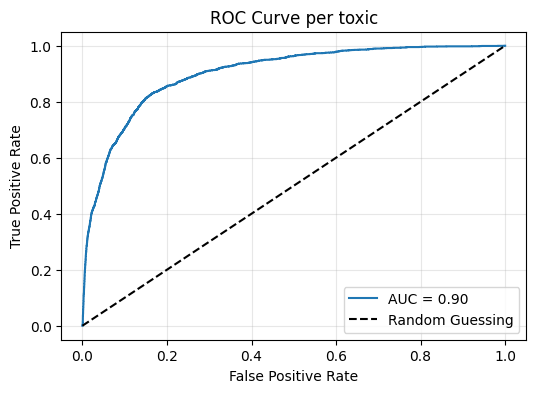

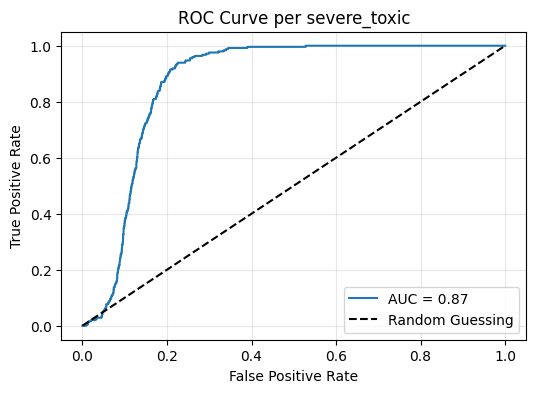

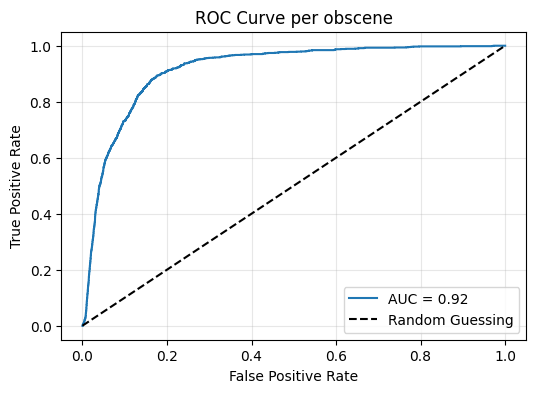

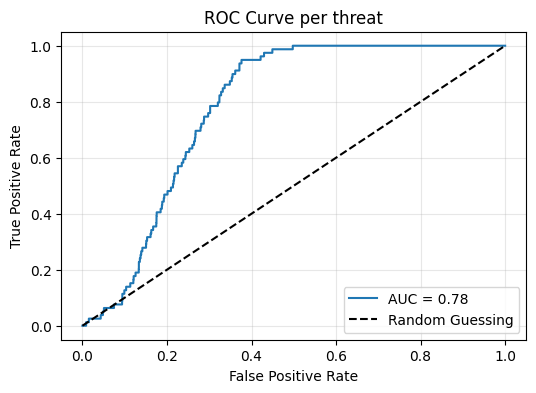

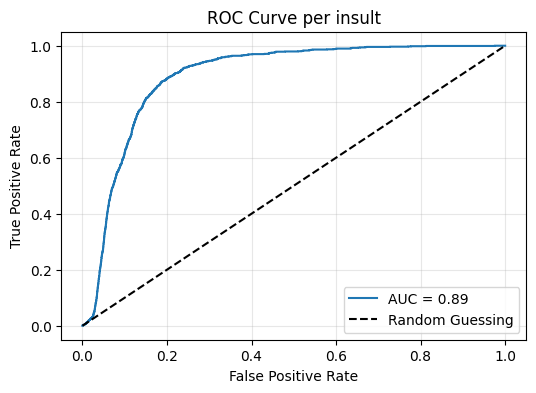

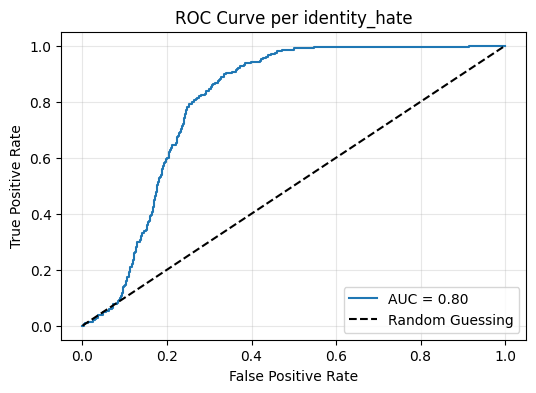

In [364]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Calcolo AUC per ogni categoria
for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test_mlsmote[:, i], y_test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title(f"ROC Curve per {category}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


Precision-Recall per toxic (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.10        1.00        
0.00      0.11        1.00        
0.00      0.12        0.99        
0.00      0.14        0.98        
0.01      0.17        0.97        
0.03      0.20        0.94        
0.10      0.26        0.90        
0.32      0.35        0.82        
0.79      0.51        0.60        
1.00      0.00        0.00        


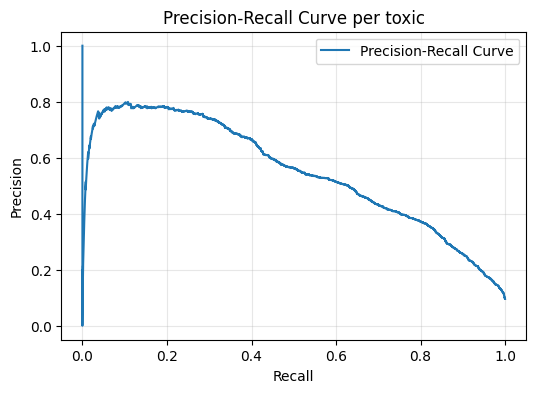


Precision-Recall per severe_toxic (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.02        1.00        
0.00      0.02        1.00        
0.00      0.02        1.00        
0.02      0.03        0.98        
0.10      0.04        0.92        
0.47      0.04        0.42        
1.00      0.00        0.00        


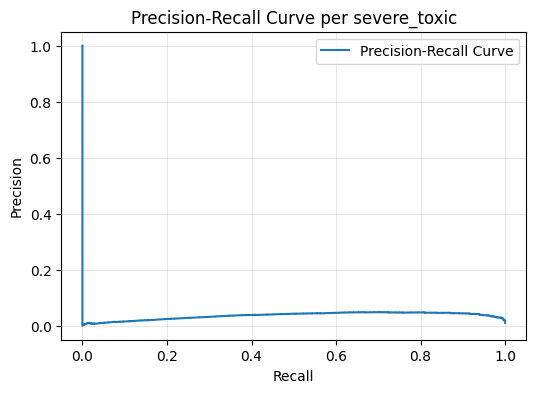


Precision-Recall per obscene (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.05        1.00        
0.00      0.06        1.00        
0.00      0.07        0.99        
0.00      0.08        0.99        
0.00      0.09        0.98        
0.01      0.12        0.97        
0.04      0.15        0.96        
0.18      0.21        0.90        
0.68      0.32        0.67        
1.00      1.00        0.00        


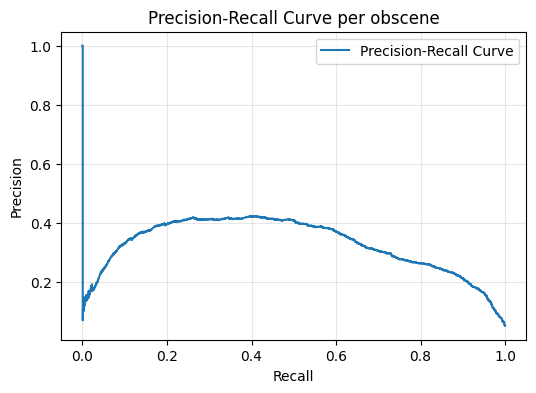


Precision-Recall per threat (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.00        1.00        
0.00      0.00        1.00        
0.00      0.00        1.00        
0.00      0.00        1.00        
0.00      0.01        1.00        
0.00      0.01        0.97        
0.02      0.01        0.84        
0.09      0.01        0.54        
0.42      0.00        0.14        
1.00      0.00        0.00        


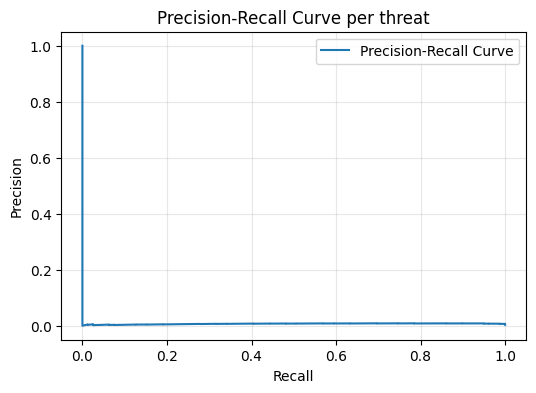


Precision-Recall per insult (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.05        1.00        
0.00      0.05        1.00        
0.00      0.06        1.00        
0.00      0.07        0.99        
0.00      0.09        0.98        
0.01      0.11        0.97        
0.04      0.14        0.95        
0.20      0.19        0.87        
0.66      0.25        0.56        
1.00      0.00        0.00        


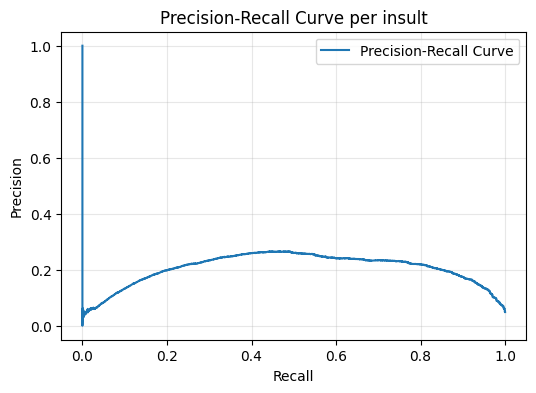


Precision-Recall per identity_hate (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.02        1.00        
0.00      0.02        0.96        
0.02      0.02        0.89        
0.11      0.02        0.64        
0.43      0.01        0.19        
1.00      0.00        0.00        


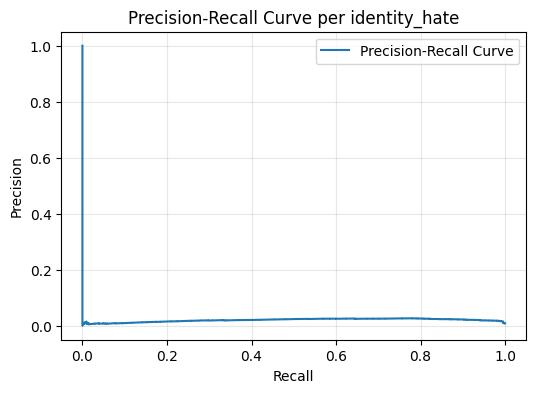

In [365]:
for i, category in enumerate(categories):
    precision, recall, thresholds = precision_recall_curve(y_test_mlsmote[:, i], y_test_pred[:, i])
    
    print(f"\nPrecision-Recall per {category} (valori campionati):")
    print(f"{'Threshold':<10}{'Precision':<12}{'Recall':<12}")
    print("-" * 34)
    
    # Indici campionati per valori distribuiti
    sampled_indices = np.linspace(0, len(thresholds) - 1, 10, dtype=int)  # Campiona 10 valori
    for idx in sampled_indices:
        print(f"{thresholds[idx]:<10.2f}{precision[idx]:<12.2f}{recall[idx]:<12.2f}")
    
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.title(f"Precision-Recall Curve per {category}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.show()

### *I valori di val_accuracy, Auc Roc e Global Accuracy non sono bassi ma alcune categorie presentano valori bassissimi di F1-score e Precision. Il modello tende a classificare molti commenti innocui come tossici.*

## <font color='red'>Creazione di un terzo modello LSTM usando come base il primo modello</font>

In [709]:
def load_model_safely(path):
    try:
        model = load_model(path)
        return model
    except Exception as e:
        print(f"Errore nel caricamento del modello: {e}")
        return None

model_checkpoint_path = "/home/gap/Scrivania/Filtro_anti_hater/anti_hater_model_stratify_400_128_6__1.keras"

first_model = load_model_safely(model_checkpoint_path)

if first_model is None:
    print("Impossibile caricare il modello. Controllare il file del modello.")
else:

    # Preservo i pesi già addestrati per evitare che vengano riaddestrati
    for layer in first_model.layers:
        layer.trainable = False  # Congelo tutti i layer esistenti
    
    print("Sommario del Modello:")
    first_model.summary()

    # Estraggo la forma dell'input, rimuovendo la dimensione del batch
    if isinstance(first_model.input_shape, tuple):
        input_shape = first_model.input_shape[1:]  # Rimuovo la dimensione del batch
    else:
        input_shape = first_model.input_shape[0][1:]  # input multipli
    
    # Creo un nuovo strato di input con la forma estratta
    inputs = Input(shape=input_shape)
    
    # Clono i layer del modello originale (escludendo l'ultimo layer di output)
    x = inputs
    for layer in first_model.layers[:-1]:
        x = layer(x)
    
    # ReLU aggiunge non-linearità al modello accelerando la convergenza
    x = Dense(256, activation='relu', name='new_dense_1')(x)
    
    # Layer di Dropout per ridurre l'overfitting
    x = Dropout(0.5, name='new_dropout')(x)

    x = Dense(128, activation='relu', name='new_dense_2')(x)

    x = Dropout(0.5, name='new_dropout_1')(x)

    x = Dense(64, activation='relu', name='new_dense_3')(x)
    
    x = Dropout(0.5, name='new_dropout_2')(x)
    
    x = Dense(32, activation='relu', name='new_dense_4')(x)
    
    # Layer di output con 6 neuroni e attivazione sigmoid per classificazione multi-label
    output_layer = Dense(6, activation='sigmoid', name='new_output_layer')(x)
    
    thirth_model = Model(inputs=inputs, outputs=output_layer)
    

    thirth_model.compile(
        optimizer='adam',  
        loss='binary_crossentropy',  # Funzione di perdita per problemi multi-label
        metrics=['accuracy']  
    )

    thirth_model.summary()   

Sommario del Modello:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 400, 128)       │    27,208,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,922,964 (312.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,307,654 (104.17 MB)

 Optimizer params: 54,615,310 (208.34 MB)

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 400, 128)       │    27,208,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_dense_1 (Dense)             │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_dropout (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_dense_2 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_dropout_1 (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_dense_3 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_dropout_2 (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_dense_4 (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_output_layer (Dense)        │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,383,334 (104.46 MB)

 Trainable params: 76,454 (298.65 KB)

 Non-trainable params: 27,306,880 (104.17 MB)

In [711]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # metrica da monitorare
    patience=3,               # numero di epoche da aspettare prima di fermarsi
    restore_best_weights=True, # ripristina i migliori pesi
    mode='min',              # minimizzare la loss
    min_delta=0.001,         # cambiamento minimo da considerare come miglioramento
    verbose=1              
)

In [712]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,             
    min_lr=1e-6,
    verbose=1
)

In [713]:
model_checkpoint_path = "anti_hater_model_stratify_400_256_128_64_32_dropout0.5_6__3.keras"

model_checkpoint = ModelCheckpoint(
    filepath=model_checkpoint_path,   # Percorso per salvare il modello
    monitor='val_loss',               # Metrica da monitorare
    save_best_only=True,              # Salvo solo il modello migliore
    save_weights_only=False,          # Salvo l'intero modello (inclusa l'architettura)
    mode='min',                       # minimizzare la val_loss
    verbose=1                        
)

## <font color='red'>Fit del terzo modello</font>

In [714]:
history = thirth_model.fit(
    X_train_balanced,
    y_train_balanced,
    validation_data=(X_val_mlsmote, y_val_mlsmote),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint], 
    verbose=1
)

print_colored(f"Il miglior modello è stato salvato in:", "blue")
print(model_checkpoint_path)

Epoch 1/10
6312/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5496 - loss: 0.1317
Epoch 1: val_loss improved from inf to 0.36338, saving model to anti_hater_model_stratify_400_256_128_64_32_dropout0.5_6__3.keras
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 263s 42ms/step - accuracy: 0.5496 - loss: 0.1317 - val_accuracy: 0.9337 - val_loss: 0.3634 - learning_rate: 0.0010
Epoch 2/10
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7276 - loss: 0.1039
Epoch 2: val_loss improved from 0.36338 to 0.29900, saving model to anti_hater_model_stratify_400_256_128_64_32_dropout0.5_6__3.keras
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 264s 42ms/step - accuracy: 0.7276 - loss: 0.1039 - val_accuracy: 0.9352 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 3/10
6312/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7599 - loss: 0.1054
Epoch 3: val_loss did not improve from 0.29900
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 263s 42ms/step - accuracy: 0.7599 - loss: 0.1054 - val_accuracy: 0.5988 - val_loss: 0.3403 - learni

## <font color='red'>Valutazione del terzo modello sul test set</font>

In [715]:
print("\nValutazione sul Test Set:")
y_test_pred = thirth_model.predict(X_test_mlsmote)  
y_test_pred_binary = (y_test_pred > 0.5).astype(int)  

test_metrics_df_3 = pd.DataFrame()
test_metrics_df_3['Category'] = categories

test_accuracies = []
test_f1_scores = []
test_precisions = []

for i in range(len(categories)):
    test_acc = accuracy_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    test_f1 = f1_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    test_prec = precision_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    test_precisions.append(test_prec)

test_metrics_df_3['Accuracy'] = test_accuracies
test_metrics_df_3['F1-Score'] = test_f1_scores
test_metrics_df_3['Precision'] = test_precisions

print("\nMetriche del Test Set:")
print(test_metrics_df_3)


print("\nInferenza su alcuni esempi del Test Set:")

num_examples = 15
for idx in range(num_examples):
    comment = X_test_mlsmote[idx]
    true_labels = y_test_mlsmote[idx]
    predicted_probs = y_test_pred[idx]
    predicted_labels = y_test_pred_binary[idx]
    
    print(f"Commento #{idx + 1}:")
    print(f" - Predetto: {predicted_labels} (probabilità: {predicted_probs.round(2)})")
    print(f" - Vero: {true_labels}")
    print("-" * 50)


Valutazione sul Test Set:
748/748 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step

Metriche del Test Set:
        Category  Accuracy  F1-Score  Precision
0          toxic  0.863929  0.514533   0.390675
1   severe_toxic  0.886990  0.025225   0.013845
2        obscene  0.879763  0.406108   0.275399
3         threat  0.892421  0.006942   0.003580
4         insult  0.871950  0.334997   0.224419
5  identity_hate  0.887909  0.016135   0.008723

Inferenza su alcuni esempi del Test Set:
Commento #1:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.24 0.01 0.05 0.01 0.04 0.01])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #2:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.04 0.   0.   0.   0.   0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #3:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.01 0.   0.   0.   0.   0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #4:
 - Predetto: [0 0 0 0 0 0] (prob

In [719]:
global_hamming_loss = hamming_loss(y_test_mlsmote, y_test_pred_binary)

global_accuracy_3 = 1 - global_hamming_loss

print_colored(f"Precisione Globale (Global Accuracy):", "blue")
print(f"{global_accuracy_3:.4f}")

Precisione Globale (Global Accuracy):
0.8805


## <font color='red'>Confronto tra i modelli</font>

In [717]:
for i, category in enumerate(categories):
    print_colored(f"Categoria {category}\n".ljust(16), "blue", end="")
    
    # Primo Modello
    print_colored(f"   Primo     Modello:".ljust(10), "red", end="")
    accuracy = test_metrics_df['Accuracy'][i]
    f1_score = test_metrics_df['F1-Score'][i]
    precision = test_metrics_df['Precision'][i]
    print_colored(f"   Accuracy: {accuracy:<10.4f} ", bg_color="blue" if accuracy == max(accuracy, test_metrics_df_2['Accuracy'][i], test_metrics_df_3['Accuracy'][i]) else "", color="black", end="")
    print_colored(f"   F1-Score: {f1_score:<10.4f} ", bg_color="blue" if f1_score == max(f1_score, test_metrics_df_2['F1-Score'][i], test_metrics_df_3['F1-Score'][i]) else "", color="black", end="")
    print_colored(f"   Precision: {precision:<10.4f}", bg_color="blue" if precision == max(precision, test_metrics_df_2['Precision'][i], test_metrics_df_3['Precision'][i]) else "", color="black", end="")
    print_colored(f"   Global Accuracy: {global_accuracy_1:<10.4f}", "black")

    # Secondo Modello
    print_colored(f"   Secondo   Modello:".ljust(10), "red", end="")
    accuracy_2 = test_metrics_df_2['Accuracy'][i]
    f1_score_2 = test_metrics_df_2['F1-Score'][i]
    precision_2 = test_metrics_df_2['Precision'][i]
    print_colored(f"   Accuracy: {accuracy_2:<10.4f} ", bg_color="blue" if accuracy_2 == max(accuracy, accuracy_2, test_metrics_df_3['Accuracy'][i]) else "", color="black", end="")
    print_colored(f"   F1-Score: {f1_score_2:<10.4f} ", bg_color="blue" if f1_score_2 == max(f1_score, f1_score_2, test_metrics_df_3['F1-Score'][i]) else "", color="black", end="")
    print_colored(f"   Precision: {precision_2:<10.4f}", bg_color="blue" if precision_2 == max(precision, precision_2, test_metrics_df_3['Precision'][i]) else "", color="black", end="")
    print_colored(f"   Global Accuracy: {global_accuracy_1:<10.4f}", "black")

    # Terzo Modello
    print_colored(f"   Terzo     Modello:".ljust(10), "red", end="")
    accuracy_3 = test_metrics_df_3['Accuracy'][i]
    f1_score_3 = test_metrics_df_3['F1-Score'][i]
    precision_3 = test_metrics_df_3['Precision'][i]
    print_colored(f"   Accuracy: {accuracy_3:<10.4f} ", bg_color="blue" if accuracy_3 == max(accuracy, accuracy_2, accuracy_3) else "", color="black", end="")
    print_colored(f"   F1-Score: {f1_score_3:<10.4f} ", bg_color="blue" if f1_score_3 == max(f1_score, f1_score_2, f1_score_3) else "", color="black", end="")
    print_colored(f"   Precision: {precision_3:<10.4f}", bg_color="blue" if precision_3 == max(precision, precision_2, precision_3) else "", color="black", end="")
    print_colored(f"   Global Accuracy: {global_accuracy_3:<10.4f}\n", "black")

Categoria toxic
   Primo     Modello:   Accuracy: 0.8697        F1-Score: 0.5272        Precision: 0.4039       Global Accuracy: 0.8844    
   Secondo   Modello:   Accuracy: 0.8695        F1-Score: 0.5242        Precision: 0.4026       Global Accuracy: 0.8844    
   Terzo     Modello:   Accuracy: 0.8639        F1-Score: 0.5145        Precision: 0.3907       Global Accuracy: 0.8805    

Categoria severe_toxic
   Primo     Modello:   Accuracy: 0.8975        F1-Score: 0.0634        Precision: 0.0350       Global Accuracy: 0.8844    
   Secondo   Modello:   Accuracy: 0.8907        F1-Score: 0.0697        Precision: 0.0382       Global Accuracy: 0.8844    
   Terzo     Modello:   Accuracy: 0.8870        F1-Score: 0.0252        Precision: 0.0138       Global Accuracy: 0.8805    

Categoria obscene
   Primo     Modello:   Accuracy: 0.8877        F1-Score: 0.4232        Precision: 0.2911       Global Accuracy: 0.8844    
   Secondo   Modello:   Accuracy: 0.8844        F1-Score: 0.4077        P

### *In blu le metriche con il valore più alto*<br>*Ho provato a colorare di bianco il testo su background blu ma è poco leggibile in quanto non è bianco puro ma color panna.*

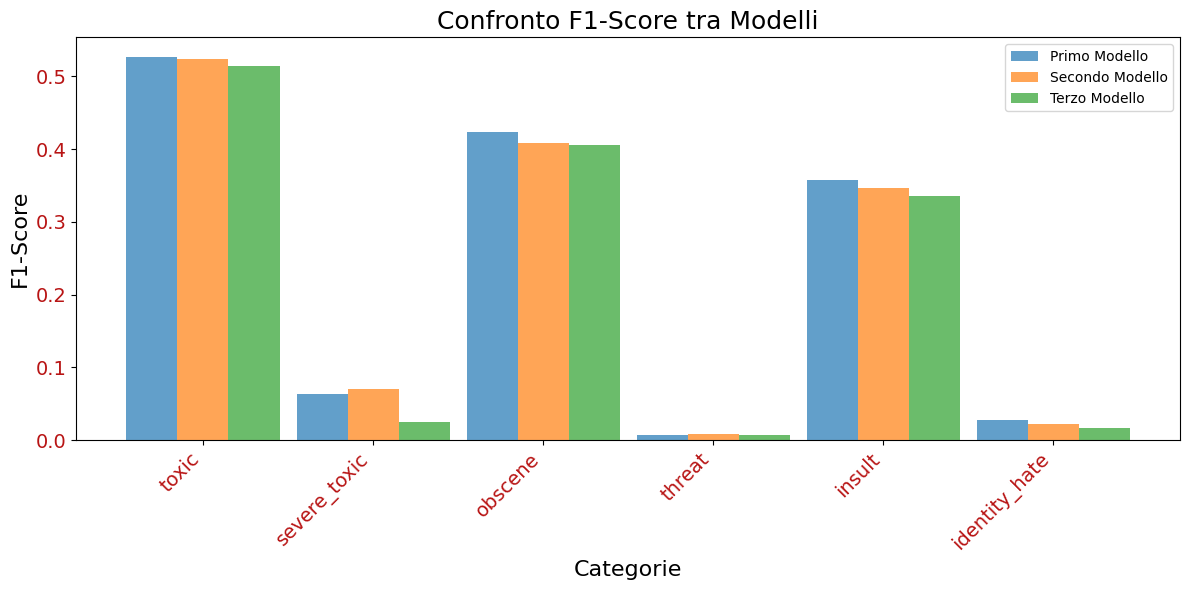

In [738]:
# Indici per le categorie
x = range(len(categories))

# Larghezza delle barre
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(x, test_metrics_df['F1-Score'], width=width, label='Primo Modello', align='center', alpha=0.7)
plt.bar([i + width for i in x], test_metrics_df_2['F1-Score'], width=width, label='Secondo Modello', align='center', alpha=0.7)
plt.bar([i + 2 * width for i in x], test_metrics_df_3['F1-Score'], width=width, label='Terzo Modello', align='center', alpha=0.7)

plt.xticks([i + width for i in x], categories, fontsize=14, rotation=45, ha='right', color="#b81414")
plt.yticks(fontsize=14, color="#b81414")
plt.xlabel("Categorie", fontsize=16, color="black")
plt.ylabel('F1-Score', fontsize=16, color="black")
plt.title('Confronto F1-Score tra Modelli', fontsize=18)
plt.legend()

plt.tight_layout()
plt.show()

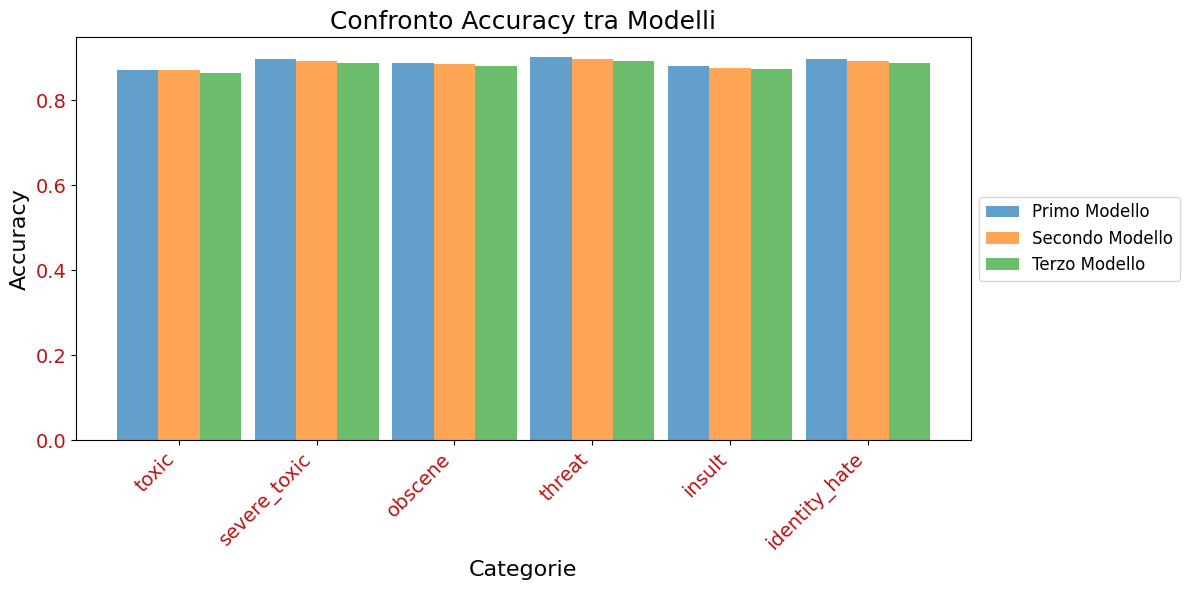

In [744]:
# Indici per le categorie
x = range(len(categories))

# Larghezza delle barre
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(x, test_metrics_df['Accuracy'], width=width, label='Primo Modello', align='center', alpha=0.7)
plt.bar([i + width for i in x], test_metrics_df_2['Accuracy'], width=width, label='Secondo Modello', align='center', alpha=0.7)
plt.bar([i + 2 * width for i in x], test_metrics_df_3['Accuracy'], width=width, label='Terzo Modello', align='center', alpha=0.7)

plt.title('Confronto Accuracy tra Modelli', fontsize=18)
plt.xticks([i + width for i in x], categories, fontsize=14, rotation=45, ha='right', color="#b81414")
plt.yticks(fontsize=14, color="#b81414")
plt.xlabel("Categorie", fontsize=16, color="black")
plt.ylabel('Accuracy', fontsize=16, color="black")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

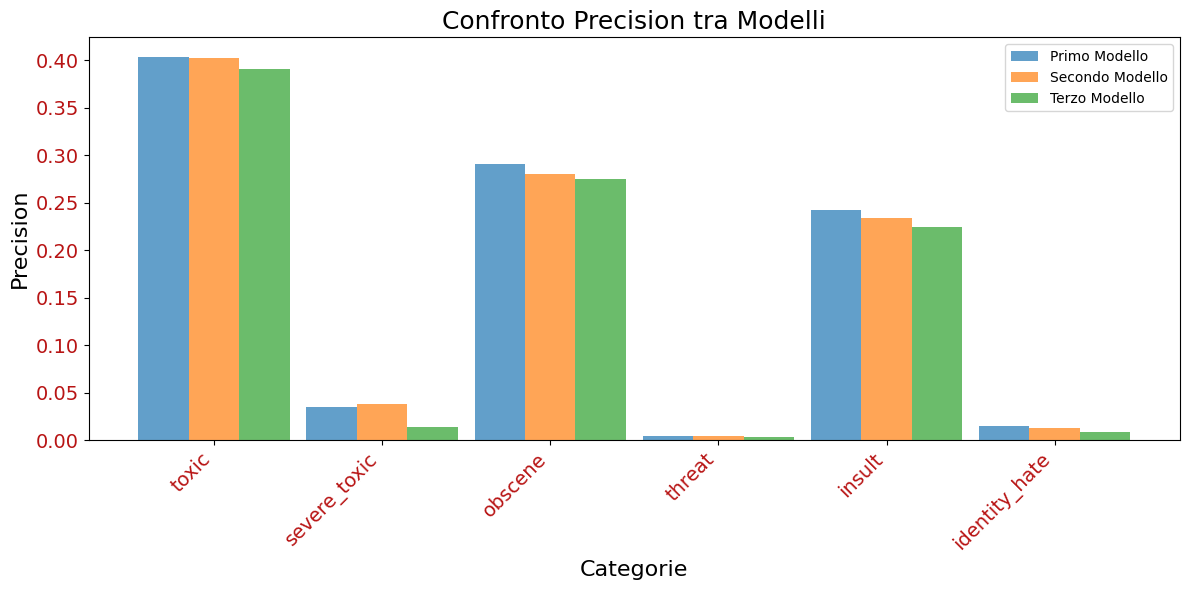

In [745]:
# Indici per le categorie
x = range(len(categories))

# Larghezza delle barre
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(x, test_metrics_df['Precision'], width=width, label='Primo Modello', align='center', alpha=0.7)
plt.bar([i + width for i in x], test_metrics_df_2['Precision'], width=width, label='Secondo Modello', align='center', alpha=0.7)
plt.bar([i + 2 * width for i in x], test_metrics_df_3['Precision'], width=width, label='Terzo Modello', align='center', alpha=0.7)

plt.title('Confronto Precision tra Modelli', fontsize=18)
plt.xticks([i + width for i in x], categories, fontsize=14, rotation=45, ha='right', color="#b81414")
plt.yticks(fontsize=14, color="#b81414")
plt.xlabel("Categorie", fontsize=16, color="black")
plt.ylabel('Precision', fontsize=16, color="black")

plt.legend()

plt.tight_layout()
plt.show()

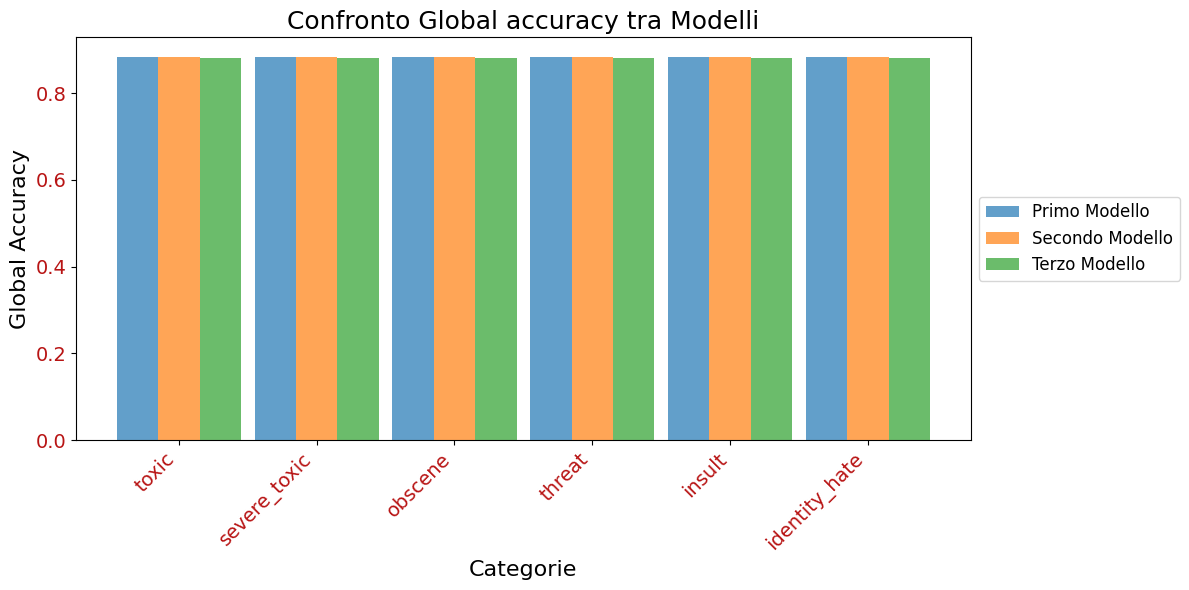

In [748]:
# Indici per le categorie
x = range(len(categories))

# Larghezza delle barre
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(x, global_accuracy_1, width=width, label='Primo Modello', align='center', alpha=0.7)
plt.bar([i + width for i in x], global_accuracy_2, width=width, label='Secondo Modello', align='center', alpha=0.7)
plt.bar([i + 2 * width for i in x], global_accuracy_3, width=width, label='Terzo Modello', align='center', alpha=0.7)

plt.title('Confronto Global accuracy tra Modelli', fontsize=18)
plt.xticks([i + width for i in x], categories, fontsize=14, rotation=45, ha='right', color="#b81414")
plt.yticks(fontsize=14, color="#b81414")
plt.xlabel("Categorie", fontsize=16, color="black")
plt.ylabel('Global Accuracy', fontsize=16, color="black")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

### *Dai risultati ottenuti si può notare che il primo modello anche essendo il più semplice ha performance migliori, di poco superiori al secondo ma decisamente migliori del terzo il quale anche avendo una struttura più complessa non riesce a catturare le dinamiche dei dati in modo efficace, risultando meno accurato e meno robusto nella classificazione*

## <font color='red'>Applico una funzione focal loss al primo modello per ridurre l'impatto delle classi di maggioranza sul calcolo della perdita.</font>

## *Dà maggiore peso ai campioni che il modello fatica a classificare correttamente.*

In [604]:
load_model_path = '/home/gap/Scrivania/Filtro_anti_hater/anti_hater_model_stratify_400_128_6__1.keras' 
model_reload_1 = load_model(load_model_path)

In [605]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)
        ce_loss = -y_true * tf.math.log(y_pred)
        focal = alpha * tf.pow(1 - y_pred, gamma) * ce_loss
        return tf.reduce_mean(tf.reduce_sum(focal, axis=-1))
    return loss

In [606]:
model_reload_1.compile(
    optimizer='adam',
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

In [607]:
model_reload_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 400, 128)       │    27,208,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,307,654 (104.17 MB)

 Trainable params: 27,307,654 (104.17 MB)

 Non-trainable params: 0 (0.00 B)

In [608]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,             
    min_lr=1e-6,
    verbose=1
)

In [609]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # metrica da monitorare
    patience=3,               # numero di epoche da aspettare prima di fermarsi
    restore_best_weights=True, # ripristina i migliori pesi
    mode='min',              # minimizzare la loss
    min_delta=0.001,         # cambiamento minimo da considerare come miglioramento
)

In [610]:
model_checkpoint_path = "anti_hater_model_reload__1.keras"

model_checkpoint = ModelCheckpoint(
    filepath=model_checkpoint_path,   # Percorso per salvare il modello
    monitor='val_loss',               # Metrica da monitorare
    save_best_only=True,              # Salvo solo il modello migliore
    save_weights_only=False,          # Salvo l'intero modello (inclusa l'architettura)
    mode='min',                       # minimizzare la val_loss
)

In [611]:
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    validation_data=(X_val_mlsmote, y_val_mlsmote), # Usa i dati di validazione originali
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint], 
    verbose=1
)

print(f"Il modello è stato salvato in: {model_checkpoint_path}")

Epoch 1/10
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6887 - loss: 0.0831
Epoch 1: val_loss improved from inf to 0.29047, saving model to anti_hater_model_reload__1.keras
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 929s 147ms/step - accuracy: 0.6887 - loss: 0.0831 - val_accuracy: 0.9000 - val_loss: 0.2905 - learning_rate: 8.0000e-06
Epoch 2/10
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6953 - loss: 0.0815
Epoch 2: val_loss did not improve from 0.29047
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 917s 145ms/step - accuracy: 0.6953 - loss: 0.0815 - val_accuracy: 0.8984 - val_loss: 0.2989 - learning_rate: 8.0000e-06
Epoch 3/10
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6923 - loss: 0.0820
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 3: val_loss did not improve from 0.29047
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 914s 145ms/step - accuracy: 0.6923 - loss: 0.0820 - val_accuracy: 0.9004 - val_loss: 0.2987 - learning_rate: 8.0000e-06
Epoch 4/

## <font color='red'>Valutazione del quarto modello (primo modello + focal loss) sul test set</font>

In [614]:
print("\nValutazione sul Test Set:")
y_test_pred = model_reload_1.predict(X_test_mlsmote)  # Predizioni sul test set
y_test_pred_binary = (y_test_pred > 0.5).astype(int)  # Converto probabilità in etichette binarie

test_metrics_df_reload_1 = pd.DataFrame()
test_metrics_df_reload_1['Category'] = categories

test_accuracies = []
test_f1_scores = []
test_precisions = []

for i in range(len(categories)):
    test_acc = accuracy_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    test_f1 = f1_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    test_prec = precision_score(y_test_mlsmote[:, i], y_test_pred_binary[:, i])
    
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    test_precisions.append(test_prec)

test_metrics_df_reload_1['Accuracy'] = test_accuracies
test_metrics_df_reload_1['F1-Score'] = test_f1_scores
test_metrics_df_reload_1['Precision'] = test_precisions

print("\nMetriche del Test Set:")
print(test_metrics_df_reload_1)


print("\nInferenza su alcuni esempi del Test Set:")

num_examples = 15
for idx in range(num_examples):
    comment = X_test_mlsmote[idx]
    true_labels = y_test_mlsmote[idx]
    predicted_probs = y_test_pred[idx]
    predicted_labels = y_test_pred_binary[idx]
    
    print(f"Commento #{idx + 1}:")
    print(f" - Predetto: {predicted_labels} (probabilità: {predicted_probs.round(2)})")
    print(f" - Vero: {true_labels}")
    print("-" * 50)


Valutazione sul Test Set:
748/748 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step

Metriche del Test Set:
        Category  Accuracy  F1-Score  Precision
0          toxic  0.866227  0.510547   0.392849
1   severe_toxic  0.893006  0.064304   0.035341
2        obscene  0.882771  0.407767   0.278788
3         threat  0.898438  0.006539   0.003378
4         insult  0.874081  0.347619   0.232686
5  identity_hate  0.891920  0.024142   0.013083

Inferenza su alcuni esempi del Test Set:
Commento #1:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.14 0.   0.01 0.   0.02 0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #2:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.02 0.   0.   0.   0.   0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #3:
 - Predetto: [0 0 0 0 0 0] (probabilità: [0.02 0.   0.01 0.   0.01 0.  ])
 - Vero: [0 0 0 0 0 0]
--------------------------------------------------
Commento #4:
 - Predetto: [0 0 0 0 0 0] (prob

In [750]:
global_hamming_loss = hamming_loss(y_test_mlsmote, y_test_pred_binary)

global_accuracy_reload_1 = 1 - global_hamming_loss

print_colored(f"Precisione Globale (Global Accuracy):", "blue")
print(f"{global_accuracy_reload_1:.4f}")

Precisione Globale (Global Accuracy):
0.8805


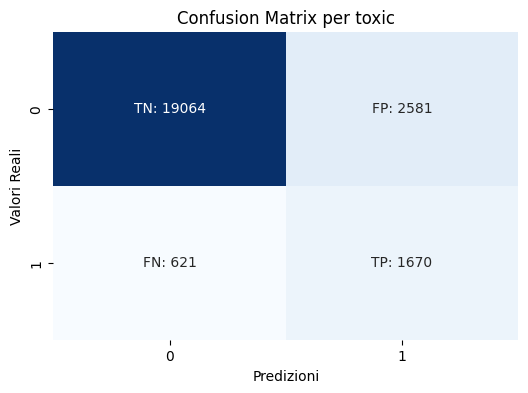

Confusion Matrix per toxic:
[[19064  2581]
 [  621  1670]]


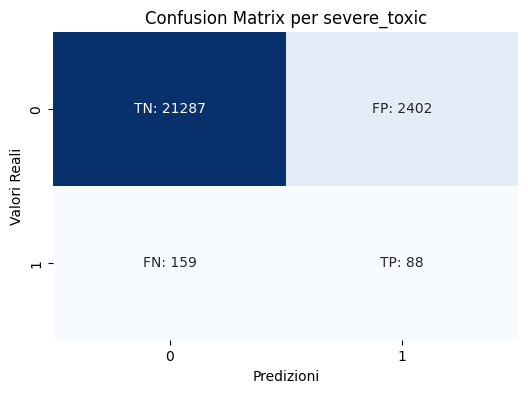

Confusion Matrix per severe_toxic:
[[21287  2402]
 [  159    88]]


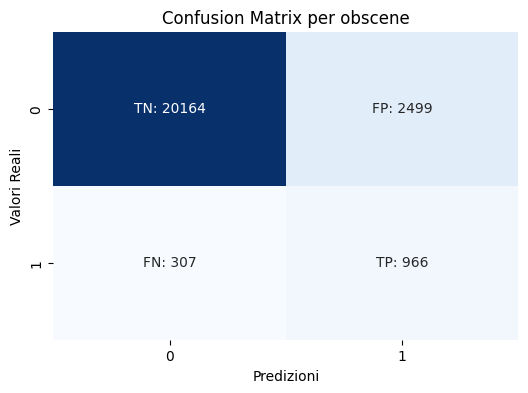

Confusion Matrix per obscene:
[[20164  2499]
 [  307   966]]


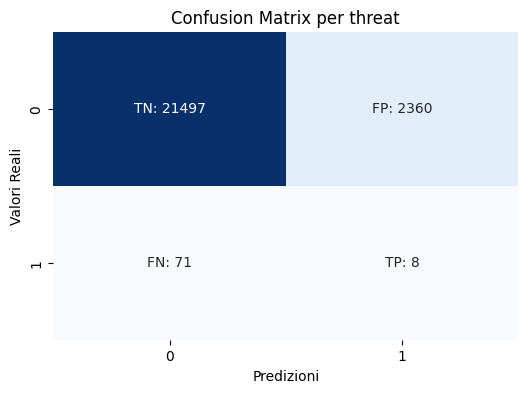

Confusion Matrix per threat:
[[21497  2360]
 [   71     8]]


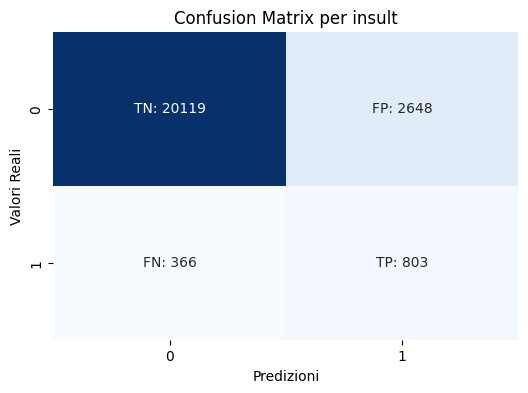

Confusion Matrix per insult:
[[20119  2648]
 [  366   803]]


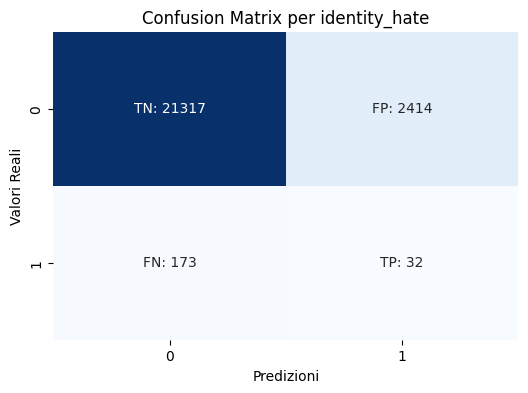

Confusion Matrix per identity_hate:
[[21317  2414]
 [  173    32]]


In [616]:
conf_matrices = multilabel_confusion_matrix(y_test_mlsmote, y_test_pred_binary)

if conf_matrices.shape[0] != len(categories):
    print("Errore: Il numero di confusion matrix non corrisponde al numero di categorie.")
else:
    for i, category in enumerate(categories):
        plt.figure(figsize=(6, 4))
        
        conf_matrix = conf_matrices[i]
        
        labels = np.array([['TN', 'FP'], ['FN', 'TP']])
        annotated_matrix = np.empty_like(conf_matrix, dtype=object)
        for row in range(conf_matrix.shape[0]):
            for col in range(conf_matrix.shape[1]):
                annotated_matrix[row, col] = f"{labels[row, col]}: {conf_matrix[row, col]}"
        
        sns.heatmap(conf_matrix, annot=annotated_matrix, fmt='', cmap='Blues', cbar=False)
        plt.title(f"Confusion Matrix per {category}")
        plt.xlabel("Predizioni")
        plt.ylabel("Valori Reali")
        plt.show()
        
        print(f"Confusion Matrix per {category}:")
        print(conf_matrix)

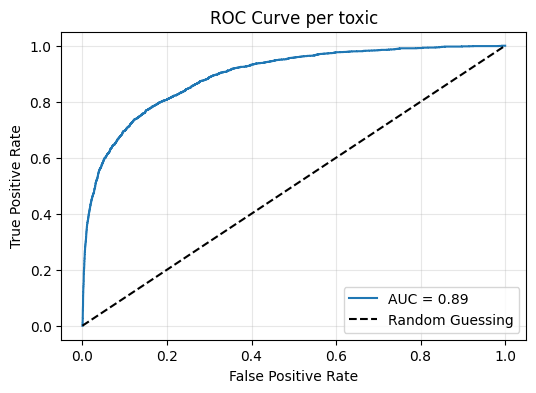

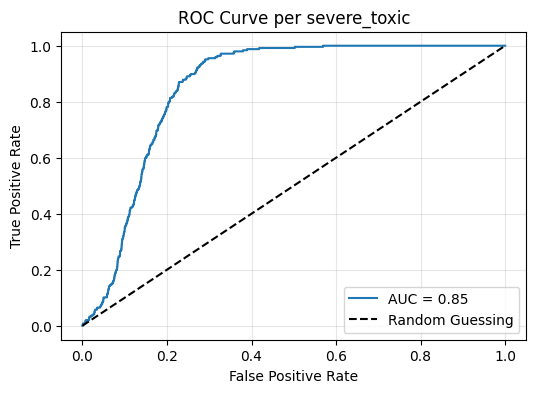

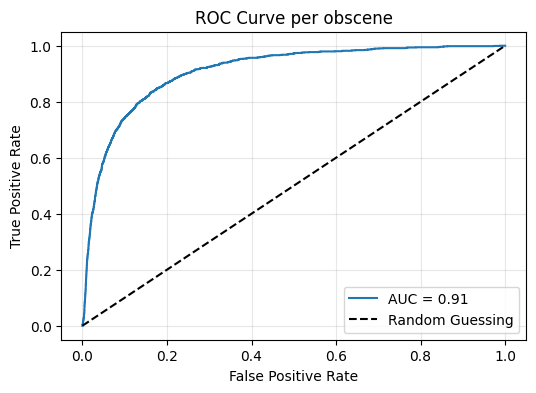

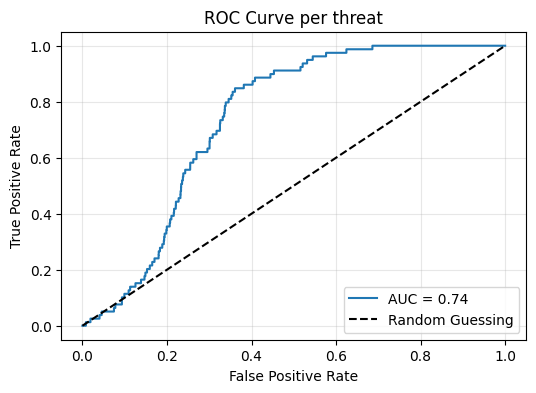

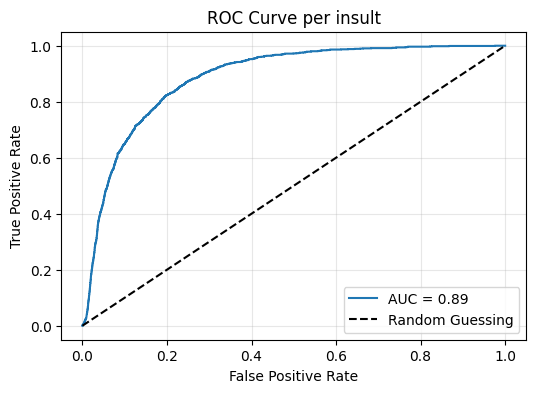

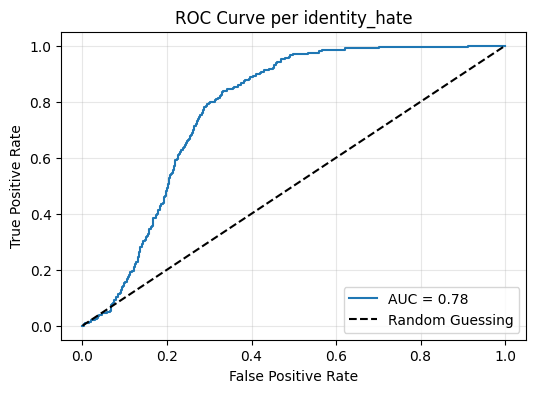

In [617]:
for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test_mlsmote[:, i], y_test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title(f"ROC Curve per {category}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


Precision-Recall per toxic (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.10        1.00        
0.00      0.11        1.00        
0.01      0.12        0.99        
0.01      0.14        0.98        
0.03      0.17        0.96        
0.07      0.20        0.93        
0.16      0.25        0.87        
0.37      0.34        0.78        
0.75      0.53        0.61        
1.00      1.00        0.00        


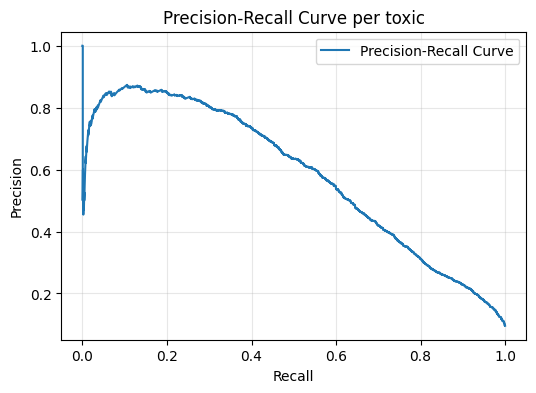


Precision-Recall per severe_toxic (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.02        1.00        
0.01      0.02        1.00        
0.02      0.02        0.99        
0.06      0.03        0.96        
0.18      0.04        0.82        
0.47      0.04        0.38        
1.00      0.00        0.00        


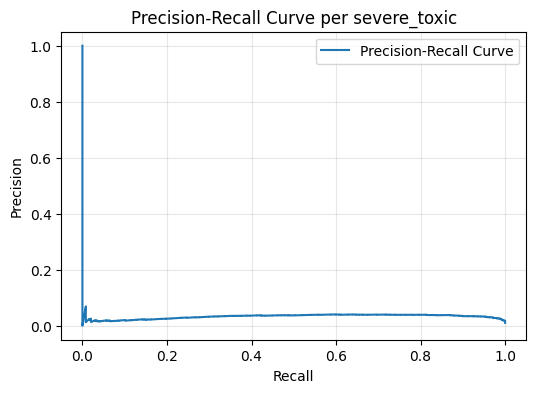


Precision-Recall per obscene (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.05        1.00        
0.00      0.06        1.00        
0.00      0.07        0.99        
0.01      0.08        0.98        
0.01      0.09        0.98        
0.03      0.11        0.96        
0.09      0.15        0.92        
0.26      0.20        0.85        
0.63      0.33        0.69        
1.00      1.00        0.00        


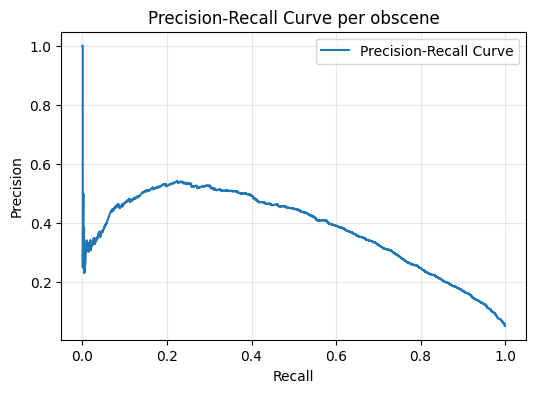


Precision-Recall per threat (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.00        1.00        
0.00      0.00        1.00        
0.00      0.00        1.00        
0.00      0.00        0.99        
0.01      0.01        0.96        
0.02      0.01        0.89        
0.06      0.01        0.73        
0.17      0.01        0.43        
0.45      0.00        0.13        
1.00      0.00        0.00        


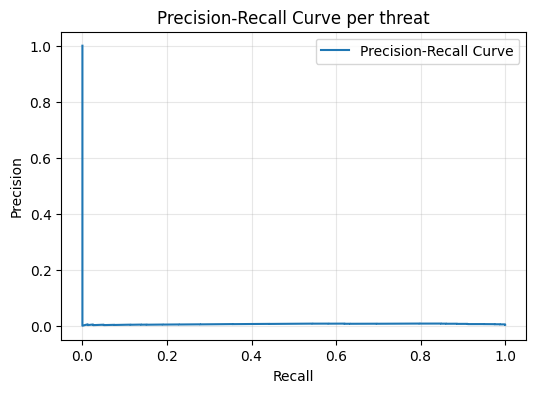


Precision-Recall per insult (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.05        1.00        
0.00      0.05        1.00        
0.00      0.06        0.99        
0.01      0.07        0.99        
0.01      0.09        0.98        
0.04      0.11        0.96        
0.10      0.13        0.91        
0.27      0.18        0.81        
0.62      0.27        0.62        
1.00      0.00        0.00        


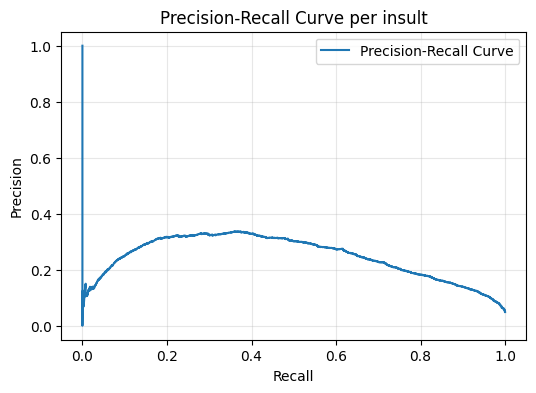


Precision-Recall per identity_hate (valori campionati):
Threshold Precision   Recall      
----------------------------------
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.01        1.00        
0.00      0.01        0.99        
0.01      0.02        0.98        
0.02      0.02        0.91        
0.07      0.02        0.82        
0.19      0.02        0.57        
0.47      0.01        0.18        
1.00      0.00        0.00        


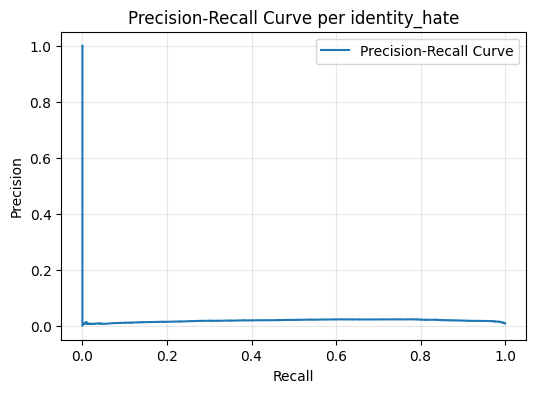

In [618]:
for i, category in enumerate(categories):
    precision, recall, thresholds = precision_recall_curve(y_test_mlsmote[:, i], y_test_pred[:, i])
    
    print(f"\nPrecision-Recall per {category} (valori campionati):")
    print(f"{'Threshold':<10}{'Precision':<12}{'Recall':<12}")
    print("-" * 34)
    
    sampled_indices = np.linspace(0, len(thresholds) - 1, 10, dtype=int)  # Campiona 10 valori
    for idx in sampled_indices:
        print(f"{thresholds[idx]:<10.2f}{precision[idx]:<12.2f}{recall[idx]:<12.2f}")
    
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.title(f"Precision-Recall Curve per {category}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.show()

### *I valori di val_accuracy, Auc Roc e Global Accuracy non sono bassi ma alcune categorie presentano valori bassissimi di F1-score e Precision. Il modello tende a classificare molti commenti innocui come tossici.*

## <font color="red">Confronto tra modelli</font>

In [652]:
for i, category in enumerate(categories):
    print_colored(f"Categoria {category}\n".ljust(16), "blue", end="")
    
    # Primo Modello
    print_colored(f"   Primo     Modello:".ljust(10), "red", end="")
    accuracy = test_metrics_df['Accuracy'][i]
    f1_score = test_metrics_df['F1-Score'][i]
    precision = test_metrics_df['Precision'][i]
    print_colored(f"   Accuracy: {f1_score:<10.4f} ", bg_color="blue" if accuracy == max(accuracy, test_metrics_df_2['Accuracy'][i], test_metrics_df_3['Accuracy'][i], test_metrics_df_reload_1['Accuracy'][i]) else "", color="black", end="")
    print_colored(f"   F1-Score: {f1_score:<10.4f} ", bg_color="blue" if f1_score == max(f1_score, test_metrics_df_2['F1-Score'][i], test_metrics_df_3['F1-Score'][i], test_metrics_df_reload_1['F1-Score'][i]) else "", color="black", end="")
    print_colored(f"   Precision: {precision:<10.4f}", bg_color="blue" if precision == max(precision, test_metrics_df_2['Precision'][i], test_metrics_df_3['Precision'][i], test_metrics_df_reload_1['Precision'][i]) else "", color="black", end="")
    print_colored(f"   Global Accuracy: {global_accuracy_1:<10.4f}", "black")

    # Secondo Modello
    print_colored(f"   Secondo   Modello:".ljust(10), "red", end="")
    accuracy_2 = test_metrics_df_2['Accuracy'][i]
    f1_score_2 = test_metrics_df_2['F1-Score'][i]
    precision_2 = test_metrics_df_2['Precision'][i]
    print_colored(f"   Accuracy: {accuracy_2:<10.4f} ", bg_color="blue" if accuracy_2 == max(accuracy, accuracy_2, test_metrics_df_3['Accuracy'][i], test_metrics_df_reload_1['Accuracy'][i]) else "", color="black", end="")
    print_colored(f"   F1-Score: {f1_score_2:<10.4f} ", bg_color="blue" if f1_score_2 == max(f1_score, f1_score_2, test_metrics_df_3['F1-Score'][i], test_metrics_df_reload_1['F1-Score'][i]) else "", color="black", end="")
    print_colored(f"   Precision: {precision_2:<10.4f}", bg_color="blue" if precision_2 == max(precision, precision_2, test_metrics_df_3['Precision'][i], test_metrics_df_reload_1['Precision'][i]) else "", color="black", end="")
    print_colored(f"   Global Accuracy: {global_accuracy_1:<10.4f}", "black")

    # Terzo Modello
    print_colored(f"   Terzo     Modello:".ljust(10), "red", end="")
    accuracy_3 = test_metrics_df_3['Accuracy'][i]
    f1_score_3 = test_metrics_df_3['F1-Score'][i]
    precision_3 = test_metrics_df_3['Precision'][i]
    print_colored(f"   Accuracy: {accuracy_3:<10.4f} ", bg_color="blue" if accuracy_3 == max(accuracy, accuracy_2, accuracy_3, test_metrics_df_reload_1['Accuracy'][i]) else "", color="black", end="")
    print_colored(f"   F1-Score: {f1_score_3:<10.4f} ", bg_color="blue" if f1_score_3 == max(f1_score, f1_score_2, f1_score_3, test_metrics_df_reload_1['F1-Score'][i]) else "", color="black", end="")
    print_colored(f"   Precision: {precision_3:<10.4f}", bg_color="blue" if precision_3 == max(precision, precision_2, precision_3, test_metrics_df_reload_1['Precision'][i]) else "", color="black", end="")
    print_colored(f"   Global Accuracy: {global_accuracy_3:<10.4f}", "black")

    # Quarto Modello
    print_colored(f"   Quarto    Modello:".ljust(10), "red", end="")
    accuracy_reload_1 = test_metrics_df_reload_1['Accuracy'][i]
    f1_score_reload_1 = test_metrics_df_reload_1['F1-Score'][i]
    precision_reload_1 = test_metrics_df_reload_1['Precision'][i]
    print_colored(f"   Accuracy: {accuracy_reload_1:<10.4f} ", bg_color="blue" if accuracy_reload_1 == max(accuracy, accuracy_2, accuracy_3, test_metrics_df_reload_1['Accuracy'][i]) else "", color="black", end="")
    print_colored(f"   F1-Score: {f1_score_reload_1:<10.4f} ", bg_color="blue" if f1_score_reload_1 == max(f1_score, f1_score_2, f1_score_3, f1_score_reload_1) else "", color="black", end="")
    print_colored(f"   Precision: {precision_reload_1:<10.4f}", bg_color="blue" if precision_reload_1 == max(precision, precision_2, precision_3, precision_reload_1) else "", color="black", end="")
    print_colored(f"   Global Accuracy: {global_accuracy_reload_1:<10.4f}\n", "black")

Categoria toxic
   Primo     Modello:   Accuracy: 0.5272        F1-Score: 0.5272        Precision: 0.4039       Global Accuracy: 0.8889    
   Secondo   Modello:   Accuracy: 0.8695        F1-Score: 0.5242        Precision: 0.4026       Global Accuracy: 0.8889    
   Terzo     Modello:   Accuracy: 0.2909        F1-Score: 0.1494        Precision: 0.0844       Global Accuracy: 0.8889    
   Quarto    Modello:   Accuracy: 0.8662        F1-Score: 0.5105        Precision: 0.3928       Global Accuracy: 0.8844    

Categoria severe_toxic
   Primo     Modello:   Accuracy: 0.0634        F1-Score: 0.0634        Precision: 0.0350       Global Accuracy: 0.8889    
   Secondo   Modello:   Accuracy: 0.8907        F1-Score: 0.0697        Precision: 0.0382       Global Accuracy: 0.8889    
   Terzo     Modello:   Accuracy: 0.6331        F1-Score: 0.0247        Precision: 0.0127       Global Accuracy: 0.8889    
   Quarto    Modello:   Accuracy: 0.8930        F1-Score: 0.0643        Precision: 0.0353   

## *Stesso confronto, ho usato il testo bianco su sfondo blu ma il testo è poco leggibile.*

In [662]:
for i, category in enumerate(categories):
    print_colored(f"Categoria {category}\n".ljust(16), "blue", end="")
    
    # Primo Modello
    print_colored(f"   Primo     Modello:".ljust(10), "red", end="")
    accuracy = test_metrics_df['Accuracy'][i]
    f1_score = test_metrics_df['F1-Score'][i]
    precision = test_metrics_df['Precision'][i]
    
    print_colored(
        f"   Accuracy: {accuracy:<10.4f} ",
        bg_color="blue" if accuracy == max(accuracy, test_metrics_df_2['Accuracy'][i], test_metrics_df_3['Accuracy'][i], test_metrics_df_reload_1['Accuracy'][i]) else "",
        color="white" if accuracy == max(accuracy, test_metrics_df_2['Accuracy'][i], test_metrics_df_3['Accuracy'][i], test_metrics_df_reload_1['Accuracy'][i]) else "black",
        end=""
    )
    print_colored(
        f"   F1-Score: {f1_score:<10.4f} ",
        bg_color="blue" if f1_score == max(f1_score, test_metrics_df_2['F1-Score'][i], test_metrics_df_3['F1-Score'][i], test_metrics_df_reload_1['F1-Score'][i]) else "",
        color="white" if f1_score == max(f1_score, test_metrics_df_2['F1-Score'][i], test_metrics_df_3['F1-Score'][i], test_metrics_df_reload_1['F1-Score'][i]) else "black",
        end=""
    )
    print_colored(
        f"   Precision: {precision:<10.4f}",
        bg_color="blue" if precision == max(precision, test_metrics_df_2['Precision'][i], test_metrics_df_3['Precision'][i], test_metrics_df_reload_1['Precision'][i]) else "",
        color="white" if precision == max(precision, test_metrics_df_2['Precision'][i], test_metrics_df_3['Precision'][i], test_metrics_df_reload_1['Precision'][i]) else "black",
        end=""
    )
    print_colored(f"   Global Accuracy: {global_accuracy_1:<10.4f}", "black")

   
    
    
   
    
    # Secondo Modello
    print_colored(f"   Secondo   Modello:".ljust(10), "red", end="")
    accuracy_2 = test_metrics_df_2['Accuracy'][i]
    f1_score_2 = test_metrics_df_2['F1-Score'][i]
    precision_2 = test_metrics_df_2['Precision'][i]
    
    print_colored(
        f"   Accuracy: {accuracy_2:<10.4f} ",
        bg_color="blue" if accuracy_2 == max(accuracy, accuracy_2, test_metrics_df_3['Accuracy'][i], test_metrics_df_reload_1['Accuracy'][i]) else "",
        color="white" if accuracy_2 == max(accuracy, accuracy_2, test_metrics_df_3['Accuracy'][i], test_metrics_df_reload_1['Accuracy'][i]) else "black",
        end=""
    )
    print_colored(
        f"   F1-Score: {f1_score_2:<10.4f} ",
        bg_color="blue" if f1_score_2 == max(f1_score, f1_score_2, test_metrics_df_3['F1-Score'][i], test_metrics_df_reload_1['F1-Score'][i]) else "",
        color="white" if f1_score_2 == max(f1_score, f1_score_2, test_metrics_df_3['F1-Score'][i], test_metrics_df_reload_1['F1-Score'][i]) else "black",
        end=""
    )
    print_colored(
        f"   Precision: {precision_2:<10.4f}",
        bg_color="blue" if precision_2 == max(precision, precision_2, test_metrics_df_3['Precision'][i], test_metrics_df_reload_1['Precision'][i]) else "",
        color="white" if precision_2 == max(precision, precision_2, test_metrics_df_3['Precision'][i], test_metrics_df_reload_1['Precision'][i]) else "black",
        end=""
    )
    print_colored(f"   Global Accuracy: {global_accuracy_1:<10.4f}", "black")

   
    
    
    
    
    # Terzo Modello
    print_colored(f"   Terzo     Modello:".ljust(10), "red", end="")
    accuracy_3 = test_metrics_df_3['Accuracy'][i]
    f1_score_3 = test_metrics_df_3['F1-Score'][i]
    precision_3 = test_metrics_df_3['Precision'][i]
   
    print_colored(
        f"   Accuracy: {accuracy_3:<10.4f} ",
        bg_color="blue" if accuracy_3 == max(accuracy, accuracy_2, accuracy_3, test_metrics_df_reload_1['Accuracy'][i]) else "",
        color="white" if accuracy_3 == max(accuracy, accuracy_2, accuracy_3, test_metrics_df_reload_1['Accuracy'][i]) else "black",
        end=""
    )
    print_colored(
        f"   F1-Score: {f1_score_3:<10.4f} ",
        bg_color="blue" if f1_score_3 == max(f1_score, f1_score_2, f1_score_3, test_metrics_df_reload_1['F1-Score'][i]) else "",
        color="white" if f1_score_3 == max(f1_score, f1_score_2, f1_score_3, test_metrics_df_reload_1['F1-Score'][i]) else "black",
        end=""
    )
    print_colored(
        f"   Precision: {precision_3:<10.4f}",
        bg_color="blue" if precision_3 == max(precision, precision_2, precision_3, test_metrics_df_reload_1['Precision'][i]) else "",
        color="white" if precision_3 == max(precision, precision_2, precision_3, test_metrics_df_reload_1['Precision'][i]) else "black",
        end=""
    )
    print_colored(f"   Global Accuracy: {global_accuracy_3:<10.4f}", "black")

   
    
    
    
    
    # Quarto Modello
    print_colored(f"   Quarto    Modello:".ljust(10), "red", end="")
    accuracy_reload_1 = test_metrics_df_reload_1['Accuracy'][i]
    f1_score_reload_1 = test_metrics_df_reload_1['F1-Score'][i]
    precision_reload_1 = test_metrics_df_reload_1['Precision'][i]
    
    print_colored(
        f"   Accuracy: {accuracy_reload_1:<10.4f} ",
        bg_color="blue" if accuracy_reload_1 == max(accuracy, accuracy_2, accuracy_3, test_metrics_df_reload_1['Accuracy'][i]) else "",
        color="white" if accuracy_reload_1 == max(accuracy, accuracy_2, accuracy_3, test_metrics_df_reload_1['Accuracy'][i]) else "black",
        end=""
    )
    print_colored(
        f"   F1-Score: {f1_score_reload_1:<10.4f} ",
        bg_color="blue" if f1_score_reload_1 == max(f1_score, f1_score_2, f1_score_3, f1_score_reload_1) else "",
        color="white" if f1_score_reload_1 == max(f1_score, f1_score_2, f1_score_3, f1_score_reload_1) else "black",
        end=""
    )
    print_colored(
        f"   Precision: {precision_reload_1:<10.4f}",
        bg_color="blue" if precision_reload_1 == max(precision, precision_2, precision_3, precision_reload_1) else "",
        color="white" if precision_reload_1 == max(precision, precision_2, precision_3, precision_reload_1) else "black",
        end=""
    )
    print_colored(f"   Global Accuracy: {global_accuracy_reload_1:<10.4f}\n", "black")

Categoria toxic
   Primo     Modello:   Accuracy: 0.8697        F1-Score: 0.5272        Precision: 0.4039       Global Accuracy: 0.8889    
   Secondo   Modello:   Accuracy: 0.8695        F1-Score: 0.5242        Precision: 0.4026       Global Accuracy: 0.8889    
   Terzo     Modello:   Accuracy: 0.2909        F1-Score: 0.1494        Precision: 0.0844       Global Accuracy: 0.8889    
   Quarto    Modello:   Accuracy: 0.8662        F1-Score: 0.5105        Precision: 0.3928       Global Accuracy: 0.8844    

Categoria severe_toxic
   Primo     Modello:   Accuracy: 0.8975        F1-Score: 0.0634        Precision: 0.0350       Global Accuracy: 0.8889    
   Secondo   Modello:   Accuracy: 0.8907        F1-Score: 0.0697        Precision: 0.0382       Global Accuracy: 0.8889    
   Terzo     Modello:   Accuracy: 0.6331        F1-Score: 0.0247        Precision: 0.0127       Global Accuracy: 0.8889    
   Quarto    Modello:   Accuracy: 0.8930        F1-Score: 0.0643        Precision: 0.0353   

## <font color="red">Analizzo alcuni commenti creati da me e altri raccolti dal web utilizzando il primo modello, con l'obiettivo di valutare le sue capacità predittive.</font>

In [ ]:
# Carico il modello salvato
model = tf.keras.models.load_model('anti_hater_model_stratify_400_128_6__1.keras')

In [5]:
# Carico il tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [6]:
def analyze_comment(comment, max_length=400):
    # Pre-processo il commento
    tokenized_sequence = tokenizer.texts_to_sequences([comment]) 
    padded_sequence = pad_sequences(tokenized_sequence, maxlen=max_length, padding='post') 

    prediction = model.predict(padded_sequence)

    results = {category: prob for category, prob in zip(categories, prediction[0])}

    return results

In [761]:
# Esempio di utilizzo
comment = "You are a stupid person!"

In [762]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [763]:
print_colored("Analisi del commento:")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.9486
severe_toxic: 0.7094
obscene: 0.8833
threat: 0.6735
insult: 0.8477
identity_hate: 0.7213


In [764]:
# Esempio di utilizzo
comment = "Your content on Instagram sucks, if I catch you on the street I will insult you"

In [765]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [766]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.9503
severe_toxic: 0.9584
obscene: 0.9531
threat: 0.9617
insult: 0.9590
identity_hate: 0.9627


In [46]:
# Esempio di utilizzo
comment = "You are beautiful"

In [47]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [48]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.1012
severe_toxic: 0.0941
obscene: 0.0793
threat: 0.0819
insult: 0.0853


In [52]:
# Esempio di utilizzo
comment = """Well done, if you combine your passion for images with knowledge of programming and data science, 
you could develop highly sought-after skills. "

In [53]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [54]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.0174
severe_toxic: 0.0163
obscene: 0.0150
threat: 0.0144
insult: 0.0156


In [58]:
# Esempio di utilizzo
comment = """Let's look at an example that shows how quantum computers can succeed where classical computers fail:
A classical computer might be great for difficult tasks like sorting a large database of molecules. 
But it struggles to solve more complex problems, such as simulating the behavior of those molecules.Today, 
if scientists want to know how a molecule behaves, they must synthesize it and experiment with it in the real world. 
If they want to know how a small change affects its behavior, they usually have to synthesize the new version and 
repeat the experiment. This is a costly and time-consuming process that impedes progress in fields as diverse as 
medicine and semiconductor design."""

In [59]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [60]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.0706
severe_toxic: 0.0356
obscene: 0.0472
threat: 0.0407
insult: 0.0502


In [767]:
# Esempio di utilizzo
comment = "You're ridiculous"

In [768]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [769]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.0998
severe_toxic: 0.0634
obscene: 0.0669
threat: 0.0623
insult: 0.0718
identity_hate: 0.0623


In [770]:
# Esempio di utilizzo
comment = "Son of a bitch"

In [771]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [772]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.9887
severe_toxic: 0.5457
obscene: 0.9543
threat: 0.3647
insult: 0.8988
identity_hate: 0.4566


In [779]:
# Esempio di utilizzo
comment = "You ugly nigger bastard"

In [780]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [781]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.9925
severe_toxic: 0.3588
obscene: 0.9485
threat: 0.1647
insult: 0.8878
identity_hate: 0.2600


In [788]:
# Esempio di utilizzo
comment = "I'm busy with work and I can't travel, but thanks to your travels I feel like I'm there, you make me dream."

In [789]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [790]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.1587
severe_toxic: 0.0870
obscene: 0.1056
threat: 0.0879
insult: 0.1155
identity_hate: 0.0950


In [791]:
# Esempio di utilizzo
comment = """I organized this trip following the advice in your article, thanks for the wonderful places you made me 
discover.!!!!!!!!"""

In [792]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [793]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.3077
severe_toxic: 0.2967
obscene: 0.2847
threat: 0.3261
insult: 0.2862
identity_hate: 0.3086


In [794]:
# Esempio di utilizzo
comment = """With that look you are obscene, you should work in a red light TV instead of making travel videos, 
shame on you.!!!!!!!!"

In [795]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [796]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.1680
severe_toxic: 0.0843
obscene: 0.0988
threat: 0.0835
insult: 0.1119
identity_hate: 0.0916


In [797]:
# Esempio di utilizzo
comment = "Don't write nonsense, go to work and get a serious job!"

In [798]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [799]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.3813
severe_toxic: 0.1116
obscene: 0.1711
threat: 0.1141
insult: 0.1754
identity_hate: 0.1152


In [800]:
# Esempio di utilizzo
comment = "Don't write nonsense, go to work and get a serious job bitch"

In [801]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [802]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.9757
severe_toxic: 0.2428
obscene: 0.8726
threat: 0.1480
insult: 0.7902
identity_hate: 0.2171


In [818]:
# Esempio di utilizzo
comment = "You are a great person and you bring really interesting and wonderful content. Thanks for what you do"

In [819]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [820]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.1906
severe_toxic: 0.1337
obscene: 0.1332
threat: 0.1368
insult: 0.1540
identity_hate: 0.1330


In [22]:
# Esempio di utilizzo
comment = "Next time I meet you on the street I will stab you"

In [23]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [24]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.5969
severe_toxic: 0.6090
obscene: 0.5700
threat: 0.6031
insult: 0.5946


In [25]:
# Esempio di utilizzo
comment = "Next time I meet you on the street I'll kill you"

In [26]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [27]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.7290
severe_toxic: 0.6938
obscene: 0.6725
threat: 0.6865
insult: 0.6866


In [31]:
# Esempio di utilizzo
comment = "I want to offer you a coffee"

In [32]:
results = analyze_comment(comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [33]:
print_colored("Analisi del commento:", "blue")
for category, prob in results.items():
    print(f"{category}: {prob:.4f}")

Analisi del commento:
toxic: 0.1705
severe_toxic: 0.1416
obscene: 0.1421
threat: 0.1484
insult: 0.1484


# *Spiegazione generale di una rete neurale*

## <font color='red'>1. Abbiamo un input</font>

### L'input è costituito da un vettore (x) di dati numerici (ad esempio, pixel di un'immagine, valori numerici di una tabella, ecc.).<br>Questo input viene normalizzato (scalato tra 0 e 1) per rendere l'addestramento più stabile. I dati vengono analizzati e trasferiti al primo strato nascosto.

## <font color='red'>2 . Passaggio dell'input ai neuroni del primo strato nascosto</font>

### Ogni neurone del primo strato nascosto riceve tutti i valori dell'input.<br>Per ciascun valore dell'input <font color='blue'>xi</font> il neurone lo moltiplica per un peso associato <font color='blue'>wi</font>(valore inizialmente casuale).<br>Il neurone calcola quindi una somma ponderata di tutti questi valori:<br><br><center><font color='blue'>z=w1x1 + w2x2 + ... + wnxn + b</font></center><br><font color='blue'>b</font> è il bias, che è un valore costante inizialmente casuale aggiunto per aumentare la flessibilità del modello. Esso permette alla rete di rappresentare relazioni più complesse, spostando la somma ponderata lontano dallo zero.

## <font color='red'>3. Passaggio dell'informazione al primo strato nascosto</font>

### L'output di ciascun neurone del primo strato (z) viene attivato attraverso una funzione di attivazione <font color='blue'> a=f(z)</font>.<br>La funzione di attivazione introduce <font color='blue'> non linearità </font> permettendo alla rete di apprendere relazioni più complesse come curve, superfici o confini non lineari tra classi ed è fondamentale nelle reti neurali in quanto un modello lineare z=w1x1 + w2x2 + ... + wnxn è semplice e può separare solo dati che siano divisibili da una linea retta, quindi si possono trovare solo a destra o a sinistra di questa retta. Se i dati invece non sono separabili linearmente (ad esempio, due classi che formano un cerchio una dentro l’altra), un modello lineare fallirà.<br>Le funzioni di attivazione trasformano l'output lineare di un neurone z=wx+b in una forma non lineare.<br>Senza funzioni di attivazione non lineari una rete neurale è equivalente a una singola trasformazione lineare anche se ha più strati perdendo la capacità di apprendere relazioni non lineari nei dati. Questo la rende equivalente a un singolo <font color='blue'>percettrone</font> limitandone drasticamente le capacità di apprendimento e rendendola inadatta a risolvere problemi complessi.<br>Le funzioni di attivazione più usate sono la <font color='blue'>Step function</font>, la <font color='blue'>Tanh</font>, la <font color='blue'>Relu</font>, <font color='blue'>Leaky Relu</font>,<font color='blue'> Elu</font> e <font color='blue'>Swish</font> per gli strati nascosti, <font color='blue'>Sigmoide</font> e <font color='blue'>Softmax</font> nello strato finale.

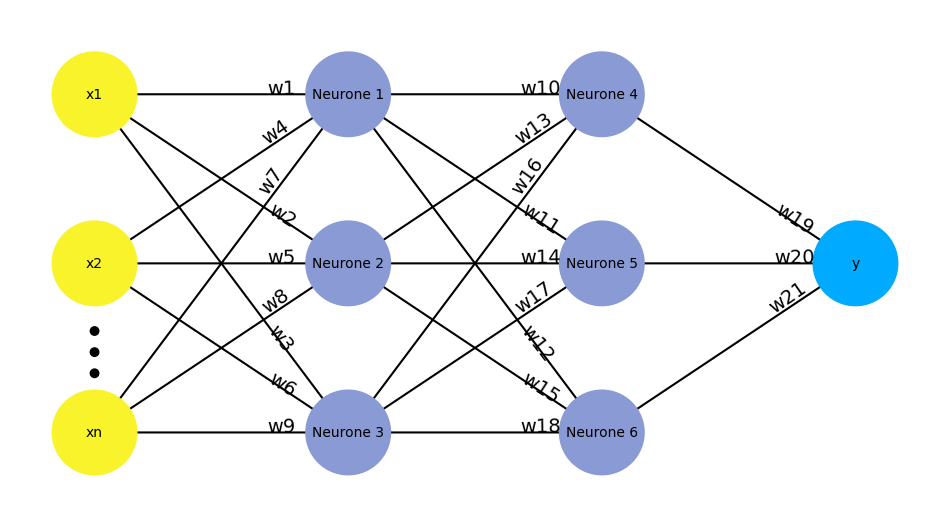

In [613]:
fig, ax = plt.subplots(figsize=(12, 12))

# Colori pastello
colors = {
    "yellow": "#f8f32b",  
    "purple": "#899ad5",   
    "blu": "#00aaff"    
}

# Posizioni dei cerchi
nodes = {
    'x1': (1, 5),
    'x2': (1, 3),
    'xn': (1, 1),
    'Neurone 1': (4, 5),
    'Neurone 2': (4, 3),
    'Neurone 3': (4, 1),
    'Neurone 4': (7, 5),
    'Neurone 5': (7, 3),
    'Neurone 6': (7, 1),
    'y': (10, 3)
}

# Nodi
for label, (x, y) in nodes.items():
    if "Neurone" in label:  # Colorare i neuroni da 1 a 6 in rosso pastello
        color = colors["purple"]
    elif label == 'y':  # Colorare il nodo di output in verde pastello
        color = colors["blu"]
    else:  # Colorare gli input in giallo pastello
        color = colors["yellow"]
    circle = plt.Circle((x, y), 0.5, color=color, zorder=2)
    ax.add_patch(circle)
    ax.text(x, y, label, fontsize=10, ha='center', va='center', zorder=3)

# Tre pallini sotto il nodo x2
dots_x2 = [(1, 2.2), (1, 1.95), (1, 1.7)]  # Posizioni dei pallini
for x, y in dots_x2:
    circle = plt.Circle((x, y), 0.05, color='black', zorder=2) 
    ax.add_patch(circle)

connections = [
    ('x1', 'Neurone 1'), ('x1', 'Neurone 2'), ('x1', 'Neurone 3'),
    ('x2', 'Neurone 1'), ('x2', 'Neurone 2'), ('x2', 'Neurone 3'),
    ('xn', 'Neurone 1'), ('xn', 'Neurone 2'), ('xn', 'Neurone 3'),
    ('Neurone 1', 'Neurone 4'), ('Neurone 1', 'Neurone 5'), ('Neurone 1', 'Neurone 6'),
    ('Neurone 2', 'Neurone 4'), ('Neurone 2', 'Neurone 5'), ('Neurone 2', 'Neurone 6'),
    ('Neurone 3', 'Neurone 4'), ('Neurone 3', 'Neurone 5'), ('Neurone 3', 'Neurone 6'),
    ('Neurone 4', 'y'), ('Neurone 5', 'y'), ('Neurone 6', 'y')
]
weights = {
    ('x1', 'Neurone 1'): 'w1', ('x1', 'Neurone 2'): 'w2', ('x1', 'Neurone 3'): 'w3',
    ('x2', 'Neurone 1'): 'w4', ('x2', 'Neurone 2'): 'w5', ('x2', 'Neurone 3'): 'w6',
    ('xn', 'Neurone 1'): 'w7', ('xn', 'Neurone 2'): 'w8', ('xn', 'Neurone 3'): 'w9',
    ('Neurone 1', 'Neurone 4'): 'w10', ('Neurone 1', 'Neurone 5'): 'w11', ('Neurone 1', 'Neurone 6'): 'w12',
    ('Neurone 2', 'Neurone 4'): 'w13', ('Neurone 2', 'Neurone 5'): 'w14', ('Neurone 2', 'Neurone 6'): 'w15',
    ('Neurone 3', 'Neurone 4'): 'w16', ('Neurone 3', 'Neurone 5'): 'w17', ('Neurone 3', 'Neurone 6'): 'w18',
    ('Neurone 4', 'y'): 'w19', ('Neurone 5', 'y'): 'w20', ('Neurone 6', 'y'): 'w21'
}

for start, end in connections:
    x_start, y_start = nodes[start]
    x_end, y_end = nodes[end]
    
    # Freccia
    ax.annotate(
        '', xy=(x_end, y_end), xytext=(x_start, y_start),
        arrowprops=dict(arrowstyle="->", color='black', lw=1.5), zorder=1
    )
    
    # Angolo di inclinazione della linea
    dx = x_end - x_start
    dy = y_end - y_start
    angle = np.degrees(np.arctan2(dy, dx))
    
    # Weights
    if (start, end) in weights:
        label_x = x_start + dx * 0.68 
        label_y = y_start + dy * 0.70
        ax.text(label_x, label_y, weights[(start, end)], fontsize=14, color='black', 
                rotation=angle+1, rotation_mode='anchor') 

ax.set_xlim(0, 11)
ax.set_ylim(0, 6)
ax.set_aspect('equal')
ax.axis('off')

plt.show()

## <font color='red'>4. Loss function e funzione di costo</font>

### Lo strato finale produce un valore predetto <font color='blue'>y pred</font> basato sull'input iniziale e sul flusso attraverso la rete e viene confrontato con <font color='blue'>y true</font> che è il valore corretto per quell'input e viene fornito dal dataset di addestramento, ad esempio, se stiamo classificando immagini di gatti e cani, y true sarà "1" per i gatti e "0" per i cani, questo perchè in un dataset ogni input ha un'etichetta associata.<br>La loss function e la funzione di costo quantificano quindi la differenza tra un valore previsto, ovvero l'output del modello per un dato input e il valore effettivo. Se le previsioni di un modello sono accurate la perdita è piccola, se le loro previsioni sono imprecise e quindi c'è parecchia differenza tra y pred e y true la perdita è grande.<br>C'è una sottile differenza però tra le due funzioni ed è dovuta al fatto che la loss function si riferisce all'errore di un esempio di addestramento, mentre una funzione di costo calcola l'errore medio in un intero set di addestramento.

## <font color='red'>5. Backpropagation</font>

### Durante la fase di backpropagation, procedendo a ritroso dall' output agli input, si calcola il gradiente dell'errore rispetto agli output di ogni strato nello stesso modo in cui viene calcolato per l'ultimo strato sempre utilizzando la funzione di costo. Una volta ottenuti i gradienti per ogni strato si calcolano i gradienti dei pesi e dei bias i quali vengono utlizzati da un algoritmo di ottimizzazione, ad esempio Adam, per aggiornare proprio i parametri della rete neurale. Dopo questi aggiornamenti inizia una nuova epoca di addestramento.